<a href="https://colab.research.google.com/github/sanosenx86/100-Days-Of-ML-Code/blob/master/colab/Test_Accelerated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Useful modules

In [ ]:
#@title Const
import numpy as np

IMAGEN_params = {
    'SSD_probe': np.array([150.0, 200.0, 250.0, 350.0, 400.0]),
    'RT_quantile': np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
}

diffusion_constant = 0.1

timestep = 10

# Pre-computed weights
IMAGEN_weights = {
    'wg': 1.0,
    'wd': np.array([1.24111245, 1.09423821, 1.33732336, 1.10659746, 0.846811,
                    0.7113083, 0.66260921]),
    'wRT_c': np.array([0.41594379, 0.49684628, 0.57553874, 0.68327873, 0.839687,
                      0.99683859, 1.24885484, 1.60178466, 2.14122737]),
    'wRT_e': np.array([0.50850644, 0.57960113, 0.66472305, 0.76945233, 0.87674657,
                      1.02268367, 1.21111342, 1.47928951, 1.88788389])}

# Make sure the stats for computing the stats following the order: weight_go, weight_stop of each probe, weight_RT_correct, weight_RT_error
IMAGEN_weights_flat = np.hstack(list(IMAGEN_weights.values()))

In [ ]:
# @title Jit ComputeCore
import matplotlib.pyplot as plt
from numba import jit, int64, float64, vectorize, boolean


def plot_trace(max_step, trace_E, trace_B, ssd, dt, bound):
    plt.plot(range(max_step), trace_E)
    plt.plot(range(max_step), trace_B)
    plt.vlines(ssd / dt, 0, bound)
    plt.show()


@jit((int64, int64, float64, float64, float64, float64, int64, int64, int64), parallel=True)
def jit_DPM_plot(onset_E, onset_B, bound, v_E, v_B, ssd=0, ddl=1000, sigma=diffusion_constant, dt=timestep):
    response = 0.0
    max_step = ddl // dt
    onset_E_step = onset_E // dt
    onset_B_step = (ssd > 0) * (onset_B + ssd) // dt
    noise_array = sigma * np.random.normal(0, dt, (2, max_step))  # sample all noises at once.
    theta_accumulate_E = 0.0
    theta_accumulate_B = 0.0
    trace_E = np.zeros(max_step)
    trace_B = np.zeros(max_step)
    for i in range(max_step):  # main iteration to simulate the process.
        # simulate execute process.
        if i > onset_E_step:  # after go onset time.
            theta_accumulate_E = theta_accumulate_E + dt * (
                    v_E + sigma * np.random.normal())  # update execution accumulation.
            trace_E[i] = theta_accumulate_E
        if theta_accumulate_E > bound:  # reached the bound, execute.
            print("Execute hit at", i)
            response = i * dt
            trace_E[i:] = bound
            plot_trace(max_step, trace_E, trace_B, ssd, dt, bound)
            return response
        # simulate stop process.
        if ssd > 0 and i > onset_B_step:  # this is a stop trial, and stop signal is perceived
            theta_accumulate_B = theta_accumulate_B - dt * (
                    v_B + sigma * np.random.normal())  # update brake accumulation.
            trace_B[i] = theta_accumulate_B
            if theta_accumulate_B <= 0:  # reached the lower bound
                print("Brake hit at", i)
                response = 0.0  # no response.
                trace_B[i:] = 0.0
                plot_trace(max_step, trace_E, trace_B, ssd, dt, bound)
                return response  # finished simulation.
        else:  # before stop onset time -- have not detected the stop signal.
            theta_accumulate_B = theta_accumulate_E  # dependent process.
            trace_B[i] = theta_accumulate_B
    print(response)
    plot_trace(max_step, trace_E, trace_B, ssd, dt, bound)
    return response


@jit(nopython=True, parallel=True)
def jit_DPM_single_trial(onset_E, onset_B, bound, v_E, v_B, ssd=0, ddl=1000, sigma=0.1, dt=timestep):
    """
      Simulate one execute process. Return the timestep when the process reaches the bound.

      :param onset_E: (int) onset time of execute process.
      :param onset_B: (int) onset time of brake process.
      :param v_E: (float) drift rate of execute process.
      :param v_B: (float) drift rate of brake process.
      :param bound: (float) the accumulation required to execute.
      :param sigma: (float): scale of noise in both process Default: 0.1.
      :param ssd: (int) the time when stop signal presents.
      :param ddl: (int) trial deadline, max wait time. Default: 0.1.
      :param dt: (int) the number of milliseconds per timestep.
  """
    response = 0.0
    max_step = int(ddl // dt)
    onset_E_step = onset_E // dt
    onset_B_step = (ssd > 0) * (onset_B + ssd) // dt
    theta_accumulate_E = 0
    theta_accumulate_B = 0
    for i in range(max_step):  # main iteration to simulate the process.
        # simulate execute process.
        if i > onset_E_step:  # after go onset time.
            noise_E = sigma * np.random.normal()
            dE = dt * (v_E + noise_E)  # update execution accumulation.
            theta_accumulate_E = theta_accumulate_E + dE
        if theta_accumulate_E > bound:  # reached the bound, execute.
            response = i * dt
            return response  # finished simulation of this trial.
        # simulate stop process.
        if 0 < onset_B_step < i:  # this is a stop trial, and stop signal is perceived
            theta_accumulate_B = theta_accumulate_B - dt * (
                    v_B + sigma * np.random.normal())  # update brake accumulation.
            if theta_accumulate_B <= 0:  # reached the lower bound
                response = 0.0  # no response.
                return response  # finished simulation.
        else:  # before stop onset time -- have not detected the stop signal.
            theta_accumulate_B = theta_accumulate_E  # dependent process.
    return response


@jit(nopython=True, parallel=True)
def jit_DPM_many_trials(onset_E, onset_B, bound, v_E_array, v_B_array, ssd_array, ddl_array, sigma=diffusion_constant,
                        dt=timestep):
    """
        Simulate many trials (one single experiment). Check jit_DPM_single_trial for details.

      :param onset_E: (int) onset time of execute process.
      :param onset_B: (int) onset time of brake process.
      :param bound: (float) the accumulation required to execute.
      :param v_E_array: (float[n_trials]) drift rate of execution process for each trial.
      :param v_B_array: (float[n_trials]) drift rate of brake process for each trial.
      :param ssd_array: (float[n_trials]) stop signal present time for each trial.
      :param ddl_array: (float[n_trials]) trial end time for each trial.
      :param sigma: (float): scale of noise in both process Default: 0.1.
      :param dt: (int) the number of milliseconds per timestep.
    """
    n_trials = len(ddl_array)
    response = np.zeros(n_trials)
    for i in range(n_trials):
        response[i] = jit_DPM_single_trial(onset_E, onset_B, bound, v_E_array[i], v_B_array[i], ssd_array[i],
                                           ddl_array[i],
                                           sigma, dt)
    return response


@jit(nopython=True, parallel=True)
def jit_DPM_many_exp(onset_E, onset_B, bound, v_E_array, v_B_array, ssd_array, ddl_array, sigma=diffusion_constant,
                     dt=timestep):
    """
        Simulate many experiments. Check jit_DPM_single_trial for details.

        :param onset_E: int
        :param onset_B: int
        :param bound: float
        :param v_E_array: float[n_exp, n_trial]
        :param v_B_array: float[n_exp, n_trial]
        :param ssd_array: float[n_exp, n_trial]
        :param ddl_array: float[n_exp, n_trial]
        :param sigma: float. default: 0.1
        :param dt: int. default: 25
    """
    n_exp = ddl_array.shape[0]
    responses = np.zeros(ddl_array.shape)
    for i in range(n_exp):
        responses[i] = jit_DPM_many_trials(onset_E, onset_B, bound, v_E_array[i], v_B_array[i], ssd_array[i],
                                           ddl_array[i],
                                           sigma, dt)
    return responses


@jit(nopython=True, parallel=True)
def jit_compute_simple_belief(ssd, alpha_0, beta_0):
    n_exp, n_trial = ssd.shape
    belief = np.zeros((n_exp, n_trial))
    for curr_exp in range(n_exp):
        alpha = alpha_0
        beta = beta_0
        for curr_trial in range(n_trial):
            belief[curr_exp, curr_trial] = alpha / (alpha + beta)
            if ssd[curr_exp, curr_trial] == 0:
                beta += 1
            else:
                alpha += 1
    return belief


# @jit(nopython=True, parallel=True)
def jit_compute_stats(trials_data, RT_quantile, SSD_probe):
    go_data = trials_data[trials_data[:, 0] == 1]  # extract all go data.
    stop_data = trials_data[trials_data[:, 0] == 0]  # extract all stop data.
    # Compute go success rate.
    p_go = np.sum(go_data[:, 2] != 0) / go_data.shape[0]
    p_stop = np.zeros_like(SSD_probe, dtype='float')
    rt_c = np.zeros_like(RT_quantile, dtype='float')
    rt_e = np.zeros_like(RT_quantile, dtype='float')
    n_probes = len(SSD_probe)
    n_quantiles = len(RT_quantile)
    # Compute stop success rate.
    for i in range(n_probes):
        probe = SSD_probe[i]
        stop_probe_data = stop_data[stop_data[:, 1] == probe]
        if stop_probe_data.shape[0] == 0:
          p_stop_probe = np.nan
        else:
          p_stop_probe = np.sum(stop_probe_data[:, 2] == 0) / stop_probe_data.shape[0]
        p_stop[i] = p_stop_probe
    # Compute reaction time quantiles
    go_correct_data = go_data[go_data[:, 2] > 0][:, 2]
    stop_error_data = stop_data[stop_data[:, 2] > 0][:, 2]
    if go_correct_data.shape[0] < 1:
        go_correct_data = np.zeros(1)
    if stop_error_data.shape[0] < 1:
        stop_error_data = np.zeros(1)
    rt_c = np.quantile(go_correct_data, RT_quantile) / 1000 # Scaling to seconds.
    rt_e = np.quantile(stop_error_data, RT_quantile) / 1000 # Scaling to seconds
    return p_go, p_stop, rt_c, rt_e


@jit(nopython=True, parallel=True)
def jit_compute_weights(stats_d, stats_RT_c, stats_RT_e):
    wg = np.array([1.0])
    wd = np.array([i.var() for i in stats_d.T])
    wd = wd / np.mean(wd)
    wRT_c = np.array([i.var() for i in stats_RT_c.T])
    wRT_c = wRT_c / np.mean(wRT_c)
    wRT_e = np.array([i.var() for i in stats_RT_e.T])
    wRT_e = wRT_e / np.mean(wRT_e)
    return wg, wd, wRT_c, wRT_e


@jit(nopython=True, parallel=True)
def jit_compute_loss(weights, pred, gold):
    loss = np.dot(weights, np.square(pred-gold))
    return loss


@vectorize([float64(boolean, float64, float64)])
def ufunc_where(condition, x, y):
    if condition:
        return x
    else:
        return y


<ipython-input-2-ccb6ecb256e9>:13: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "jit_DPM_plot" failed type inference due to: Untyped global name 'plot_trace': cannot determine Numba type of <class 'function'>

File "<ipython-input-2-ccb6ecb256e9>", line 34:
def jit_DPM_plot(onset_E, onset_B, bound, v_E, v_B, ssd=0, ddl=1000, sigma=diffusion_constant, dt=timestep):
    <source elided>
            trace_E[i:] = bound
            plot_trace(max_step, trace_E, trace_B, ssd, dt, bound)
            ^

  @jit((int64, int64, float64, float64, float64, float64, int64, int64, int64), parallel=True)
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "jit_DPM_plot" was compiled in object mode without forceobj=True.

File "<ipython-input-2-ccb6ecb256e9>", line 14:
@jit((int64, int64, float64, float64, float64, float64, int64, int64, int64), parallel=True)
def jit_DPM_plot(onset_E, onset_B, bound,

In [ ]:
# @title ComputeCore
"""
Core module for simulation dependent process and perform necessary computation.
"""


def simulate_and_plot_dependent_process(onset_E, onset_B, bound, v_E, v_B, ssd=0, ddl=1000,
                                        sigma=diffusion_constant, dt=timestep):
    response = jit_DPM_plot(onset_E, onset_B, bound, v_E, v_B, ssd, ddl, sigma, dt)
    return response

simulate_dependent_process = jit_DPM_single_trial
"""
    Simulate one execute process. Return the timestep when the process reaches the bound.

    :param onset_E: (int) onset time of execute process.
    :param onset_B: (int) onset time of brake process.
    :param bound: (float) the accumulation required to execute.
    :param v_E: (float) drift rate of execute process.
    :param v_B: (float) drift rate of brake process.
    :param sigma: (float): scale of noise in both process Default: 0.1.
    :param ssd: (int) the time when stop signal presents.
    :param ddl: (int) trial deadline, max wait time. Default: 0.1.
    :param dt: (int) the number of milliseconds per timestep.
    :param using_jit: (bool) use JIT acceleration.
    :return: theta (float): the time of execution. 0 means no action.
"""


def compute_stats(trials_data, RT_quantiles, SSD_probe, flatten=True):
    """ Compute the go prob, stop prob per probe, RTc quantiles, RTe quantiles
        Each column of trials data represents:
            [trial_type, trial_ssd, response]
    """
    p_go, p_stop, rt_c, rt_e = jit_compute_stats(trials_data, RT_quantiles, SSD_probe)
    if flatten:
        return np.hstack([p_go, p_stop, rt_c, rt_e])
    return {'p_go': p_go, 'p_stop': p_stop, 'rt_c': rt_c, 'rt_e': rt_e}


def compute_simple_belief(ssd, alpha_0=0.2, beta_0=0.8):
    """
        Compute dynamic belief, given trial ssd.

        :param ssd: float[n_exp, n_trial]
        :param alpha_0: float  initial belief alpha
        :param beta_0: float  initial belief beta
    """
    return jit_compute_simple_belief(ssd, alpha_0, beta_0)


def compute_weights(full_SST_stats):
    """
        Computes the weights for computing loss.
    """
    stats_d = np.vstack([indiv_stats['p_stop'] for indiv_stats in full_SST_stats])
    stats_RT_c = np.vstack([indiv_stats['rt_c'] for indiv_stats in full_SST_stats])
    stats_RT_e = np.vstack([indiv_stats['rt_e'] for indiv_stats in full_SST_stats])
    wg, wd, wRT_c, wRT_e = jit_compute_weights(stats_d, stats_RT_c, stats_RT_e)
    return {'wg': wg, 'wd': wd, 'wRT_c': wRT_c, 'wRT_e': wRT_e}


def flatten_weights(weights):
    return np.hstack([weights['wg'], weights['wd'], weights['wRT_c'], weights['wRT_e']])


def compute_loss(weights, pred, gold):
    """
        Computes loss of prediction by stats. Flatten pred, gold to following order: wg, wd, wRT_c, wRT_e
    """
    loss = jit_compute_loss(weights, pred, gold)
    return loss


In [ ]:
#@title SSTData
import numpy as np
import pandas as pd


class SSTData:
    """
    An intermediate data structure provides necessary interfaces for easier processing experimental or simulated data.
    Notice it just serves as a dictionary containing necessary keys.
    Under safe mode, it will run necessary checks to guarantee this data has equal length of all attributes.

    It has following attributes:
        data: a dict contains all experimental data. It has following keys.
            subject_id: subject id. 0(default): simulated data.
            length: trial length. default: 1000
            ssd: time of stop signal. 0(default): go trial. other: time of stop signal.
            trial_type: type of trials. 0: stop trial. 1(default): go trial.
            stim_direction: direction of go signal. 0: simulated. 1: left. 2: right.
            response: response of subject in this trial. 0(default): no response. other: time of response.
            resp_direction: direction of subject response. 0(default): none. 1: left. 2:right.
            outcome: if the response is correct. Encoded by following:
                    0: go correct / stop correct.
                    1: go timeout / stop failed.
                    2: go wrong direction / stop too early.
    """

    outcome_results = ['GO_correct', 'STOP_correct', 'GO_timeout', 'STOP_failed', 'GO_wrong_direction',
                       'STOP_too_early']

    def __init__(self, subject_id=np.array([]), length=np.array([]), ssd=np.array([]), trial_type=np.array([]),
                 stim_direction=np.array([]), response=np.array([]), resp_direction=np.array([]), outcome=np.array([])):
        self.data = {'subject_id': np.array(subject_id),
                     'length': np.array(length),
                     'ssd': np.array(ssd),
                     'trial_type': np.array(trial_type),
                     'stim_direction': np.array(stim_direction),
                     'response': np.array(response),
                     'resp_direction': np.array(resp_direction),
                     'outcome': np.array(outcome)}

    def read_IMAGEN(self, IMAGEN_dataframe):
        """ Create SSTData from IMAGEN dataset."""
        n_records = IMAGEN_dataframe.shape[0]
        self.__init__(subject_id=IMAGEN_dataframe['id'].astype('int'),
                      length=np.ones(n_records) * 1000,
                      ssd=IMAGEN_dataframe['Delay'].fillna(0).astype('int'),
                      trial_type=IMAGEN_dataframe['Trial Category'].replace("GO", 1).replace("STOP_VAR", 0),
                      stim_direction=IMAGEN_dataframe['Stimulus Presented'].replace("LeftArrow", 1).replace(
                          "RightArrow", 2),
                      response=IMAGEN_dataframe['Relative Response Time'].fillna(0).astype('float'),
                      resp_direction=IMAGEN_dataframe['Response made by subject'].fillna(0).replace('', 0).replace("B",
                                                                                                                   1).replace(
                          "C",
                          2),
                      outcome=IMAGEN_dataframe['Response Outcome']
                      .replace("GO_SUCCESS", 0)
                      .replace("STOP_SUCCESS", 0)
                      .replace("STOP_FAILURE", 1)
                      .replace("GO_TOO_LATE", 1)
                      .replace("STOP_TOO_EARLY_RESPONSE", 2)
                      .replace("GO_WRONG_KEY_RESPONSE", 2))
        return self

    @staticmethod
    def from_IMAGEN(IMAGEN_dataframe):
        """ Create SSTData from IMAGEN dataset."""
        data = SSTData()
        data.read_IMAGEN(IMAGEN_dataframe)
        return data

    def read_simulation(self, length, trial_type, ssd, response, stim_direction=None, resp_direction=None):
        """ Create SSTData from simulation."""
        length = length.reshape(-1)
        trial_type = trial_type.reshape(-1)
        ssd = ssd.reshape(-1)
        response = response.reshape(-1)
        n_records = len(length)
        outcome = np.zeros(n_records)
        outcome[(trial_type == 0) & (response > 0)] = 1
        outcome[(trial_type == 1) & (response == 0)] = 1
        outcome[(trial_type == 0) & (response < ssd) & (response > 0)] = 2
        if stim_direction is not None and resp_direction is not None:
          outcome[stim_direction != resp_direction] = 2
        subject_id = np.zeros(n_records)
        if stim_direction is None:
            stim_direction = np.zeros(n_records)
        if resp_direction is None:
            resp_direction = np.zeros(n_records)
        self.__init__(subject_id=subject_id,
                      length=length,
                      ssd=ssd,
                      trial_type=trial_type,
                      stim_direction=stim_direction,
                      response=response,
                      resp_direction=resp_direction,
                      outcome=outcome)
        return self

    @staticmethod
    def from_simulation(length, trial_type, ssd, response, stim_direction=None, resp_direction=None):
        """ Create SSTData from simulation."""
        data = SSTData()
        data.read_simulation(length, trial_type, ssd, response, stim_direction, resp_direction)
        return data

    @staticmethod
    def from_standard(standard_dataframe: pd.DataFrame):
        data = SSTData()
        data.data = standard_dataframe.to_dict(orient='list')
        return data

    def read_CANTAB(self, CANTAB_dataframe: pd.DataFrame):
        outcome = CANTAB_dataframe['trialsOutcome'].replace('correct', 0).replace('incorrect', 1).replace('timeout', 1)
        trial_type = CANTAB_dataframe['trialsType'].replace('stop', 0).replace('go', 1)
        wrong_direction_idx = np.logical_and(trial_type,
                                             CANTAB_dataframe['trialsStimulusDirection'] != CANTAB_dataframe[
                                                 'trialsChosenDirection'])
        outcome[wrong_direction_idx] = 2
        self.__init__(subject_id=CANTAB_dataframe['subject'],
                      length=CANTAB_dataframe['trialsEnd'] - CANTAB_dataframe['trialsStimulusPresentedAt'],
                      ssd=CANTAB_dataframe['trialsSSD'].fillna(0),
                      trial_type=trial_type,
                      stim_direction=CANTAB_dataframe['trialsStimulusDirection'].replace('left', 1).replace('right', 2),
                      response=CANTAB_dataframe['trialsReactionTime'].fillna(0),
                      resp_direction=CANTAB_dataframe['trialsChosenDirection'].replace('none', 0).replace('left',
                                                                                                          1).replace(
                          'right', 2),
                      outcome=outcome)
        return self

    @staticmethod
    def from_CANTAB(CANTAB_dataframe: pd.DataFrame):
        data = SSTData()
        data.read_CANTAB(CANTAB_dataframe)
        return data

    def to_pandas(self):
        return pd.DataFrame(self.data)

    def __repr__(self):
        return self.to_pandas().to_string()

    def append(self, data):
        self.data['subject_id'] = np.concatenate([self.data['subject_id'], data.data['subject_id']])
        self.data['length'] = np.concatenate([self.data['length'], data.data['length']])
        self.data['ssd'] = np.concatenate([self.data['ssd'], data.data['ssd']])
        self.data['trial_type'] = np.concatenate([self.data['trial_type'], data.data['trial_type']])
        self.data['stim_direction'] = np.concatenate([self.data['stim_direction'], data.data['stim_direction']])
        self.data['response'] = np.concatenate([self.data['response'], data.data['response']])
        self.data['resp_direction'] = np.concatenate([self.data['resp_direction'], data.data['resp_direction']])
        self.data['outcome'] = np.concatenate([self.data['outcome'], data.data['outcome']])
        return self


In [ ]:
#@title SSDProvider
import numpy as np


class _BaseSSDProvider:
    """ Automatically tracks and changes SSD. Use this interface to implement customized experiment."""

    def __init__(self, update_step, starting_SSD, update_rule):
        self.update_step = update_step
        self.starting_SSD = starting_SSD
        self.current_SSD = starting_SSD
        self.update_rule = update_rule
        if not (type(update_step) is int or type(update_step) is float) and not (len(update_step) == len(starting_SSD)):
            raise AssertionError("Update step should either be a number, or be consistent with starting_SSD")
        if not ((type(starting_SSD) is int or type(starting_SSD) is float) and update_rule.shape[0] == 1 and
                update_rule.shape[1] == 3) and not (
                update_rule.shape[0] == len(starting_SSD) or update_rule.shape[1] == 3):
            raise AssertionError(
                "Update rule should have shape [#num of starting_SSD, 3], defining behaviors under (stop success, "
                "stop failed, stop too early)")

    def provide(self):
        """ Provide a SSD. Call this method to obtain a SSD. """
        raise NotImplementedError("Do not use base StaircaseProvider")

    def update(self, response):
        """ Update SSD tracker. Call this method to change SSD automatically. """
        raise NotImplementedError("Do not use base StaircaseProvider")

    def reset(self):
        """ Reset SSD tracker."""
        raise NotImplementedError("Do not use base StaircaseProvider")


class IMAGENSSDProvider(_BaseSSDProvider):
    def __init__(self, update_step=50, starting_SSD=150):
        super().__init__(update_step, starting_SSD, np.array([[1, 1, 1]]))

    def provide(self):
        return self.current_SSD

    def update(self, response):
        if response == 0:  # if stop success
            self.current_SSD += self.update_step
            self.current_SSD = min(950, self.current_SSD)
        else:
            self.current_SSD -= self.update_step
            self.current_SSD = max(0, self.current_SSD)

    def reset(self):
        self.current_SSD = self.starting_SSD


class RandomProvider(_BaseSSDProvider):
    def __init__(self, **kwargs):
        self.stored_response = 0
        self.last_provided = 0

    def provide(self):
        """ Provide a SSD. Call this method to obtain a SSD. """
        if self.stored_response > 0:
          self.last_provided = self.stored_response
          self.stored_response = 0
        else:
          self.last_provided = max(50, np.random.uniform(0, 1) * 900 +50)
        return self.last_provided

    def update(self, response):
        """ Update SSD tracker. Call this method to change SSD automatically. """
        if 0 < response < self.last_provided:
          self.stored_response = max(50, response - 50)

    def reset(self):
        """ Reset SSD tracker."""
        self.last_provided = 0
        self.stored_response = 0


## Functional Classes

In [ ]:
# @title Analyzer

class StandardAnalyzer:

    def __init__(self, target_data, quantiles, n_probe=5):
        self.target_data = target_data.to_pandas()
        self._raw_target_data = target_data
        self.target_stats = None
        self._flatten_target_stats = None
        self.weight = None
        self._flatten_weight = None
        self.RT_quantile = quantiles
        self.SSD_probe = np.array([])
        self.go_RT = np.array([])
        self.SSDs = np.array([])
        self._analyze_probe(n_probe)
        self.analyze_result = None

    def _analyze_probe(self, n_probe=5):
        ssds = self.target_data['ssd'][self.target_data['trial_type'] == 0].value_counts().sort_values(
            ascending=False).index[:n_probe]
        self.SSD_probe = np.array([i for i in ssds])

    @staticmethod
    def sample_qc(analyzer, result_dict):
        return analyzer.target_stats

    def analyze(self, qc=None):
        """
          give the basic analysis of target data.
          qc: a quality control function. Accepts an analyzer and result dictionary, and returns a boolean.
        """
        go_idx = self.target_data["trial_type"] == 1
        stop_idx = self.target_data['trial_type'] == 0
        go_rt = self.target_data['response'][go_idx]
        p_go = np.mean(go_rt>0)
        mean_go = np.mean(go_rt[go_rt > 0].to_numpy())
        std_go = np.std(go_rt[go_rt > 0].to_numpy())
        idx = go_rt.index[go_rt == 0]
        self.go_RT = go_rt[go_rt > 0]
        self.SSDs = self.target_data[stop_idx]['ssd'].to_numpy()
        go_rt[idx] = self.target_data['length'][idx]
        self.target_stats = self.compute_stats(self._raw_target_data, flatten=False)
        self._flatten_target_stats = np.hstack(
            [self.target_stats['p_go'], self.target_stats['p_stop'], self.target_stats['rt_c'],
             self.target_stats['rt_e']])
        p_stop = (self.target_data[stop_idx]['outcome'] == 0).sum() / stop_idx.sum()
        mean_ssd = np.mean(self.target_data[stop_idx]['ssd'])
        nthssrt = np.quantile(go_rt, p_stop) - mean_ssd
        medianssrt = np.median(go_rt) - mean_ssd
        qced = True
        onset_e_init = self.go_RT.min()/2
        incp_e_init = (11 - np.log(np.nanvar(self.go_RT)))/30  # a very random heuristics
        result_dict = {"p_go": p_go, "onset_e_init": onset_e_init, "v_e_init": incp_e_init,
                       "mean_go": mean_go,
                       "std_go": std_go, 'p_stop': p_stop, 'nthssrt': nthssrt, 'medianssrt': medianssrt,
                       'thres_init': (mean_go - onset_e_init) * incp_e_init,
                       "mean_ssd": mean_ssd}
        if qc is not None:
            qced = qc(self, result_dict)
        result_dict['pass_qc'] = qced
        self.analyze_result = result_dict
        return result_dict

    def set_weight(self, weight):
        self.weight = weight
        self._flatten_weight = np.hstack(
            [self.weight['wg'], self.weight['wd'], self.weight['wRT_c'], self.weight['wRT_e']])

    def compute_stats(self, subject_SST_data, flatten=True):
        """
        Compute the stats {p_go, p_stop_d, RT_c, RT_e} given the SST data.

        :param subject_SST_data: a SST_data instance of a subject.
        :return: a dict contains (p_go, p_stop_d, RT_c, RT_e).
        """
        extract_data = subject_SST_data.data
        trials_data = np.array([extract_data['trial_type'], extract_data['ssd'], extract_data['response']]).T
        return compute_stats(trials_data, self.RT_quantile, self.SSD_probe, flatten)

    def compute_loss(self, pred):
        """
        Compute the loss of predicted value versus target value. Weight must have be defined.
        Both stats are dict computed by compute_stats method.

        :param pred: The predicted stats.
        :param gold: The target stats.
        :return: a float loss value.
        """

        assert self._flatten_weight is not None
        return compute_loss(self._flatten_weight, pred, self._flatten_target_stats)


class ImagenAnalyzer(StandardAnalyzer):
    """
    Analyzer is to compute stats of a given set of data. It can also be used to compute weights from a bunch of data.
    """

    def __init__(self, target_data, quantiles, n_probe=5):
        super().__init__(SSTData.from_IMAGEN(target_data), quantiles, n_probe)



In [ ]:
#@title IMAGEN dataset processing

class IMAGEN_proc:
  IMAGEN_df = None
  subjects = []
  raw_weights = {'var_p_go': [], 'var_p_stop':{}, 'var_RT_c':[], 'var_RT_e':[]}

  @classmethod
  def get_analyzer(cls, num, quantiles, n_probes=5):
    """
      produce an analyzer, and initialize its weight
    """
    analyzer = ImagenAnalyzer(cls.extract_subject_df(num), quantiles, n_probes)
    probes = analyzer.SSD_probe
    wg = np.ones(1)
    wg = wg / wg.mean()
    print(probes)
    wd = np.array([cls.raw_weights['var_p_stop'][i] for i in probes])
    wd = wd / wd.mean()
    wRT_c = cls.raw_weights['var_RT_c']
    wRT_c = wRT_c / wRT_c.mean()
    wRT_e = cls.raw_weights['var_RT_e']
    wRT_e = wRT_e / wRT_e.mean()
    weight = {'wg': wg, 'wd': wd, 'wRT_c':wRT_c, 'wRT_e':wRT_e}
    analyzer.set_weight(weight)
    return analyzer

  @staticmethod
  def imagen_default_qc(df):
    if (df['Response Outcome']=='GO_SUCCESS').fillna(0).sum()/(df['Trial Category']=='GO').sum() < 0.7:
      # print('low correct go rate', (df['Response Outcome']=='GO_SUCCESS').fillna(0).sum()/(df['Trial Category']=='GO').sum())
      return True
    if not (0.8 > (df['Response Outcome']=='STOP_SUCCESS').fillna(0).sum()/(df['Trial Category']=='STOP_VAR').sum() > 0.3):
      # print('abnormal stop success rate', (df['Response Outcome']=='STOP_SUCCESS').fillna(0).sum()/(df['Trial Category']=='STOP_VAR').sum())
      return True
    return False

  @classmethod
  def initialize_class(cls, total_df, qc=None, weight_quantiles=None):
    """
      qc accepts a subject dataframe, and return a boolean if this subject is qualified.
      if need to compute raw weight, weight_quantiles must be passed.
    """

    #preprocessing
    df = total_df.drop(index=total_df.index[total_df['Response Outcome']=="STOP_TOO_EARLY_RESPONSE"])
    cls.IMAGEN_df = df.drop(index=df.index[df['Trial'].isna()])
    cls.subjects = list(set(cls.IMAGEN_df['id']))

    #quality control
    if qc is not None:
      drop_ids = []
      for i in cls.subjects:
        df = cls.IMAGEN_df[cls.IMAGEN_df['id']==i]
        if qc(df):
          drop_ids.append(i)
          # print("QC--Dropped id: ", i)
      cls.IMAGEN_df = cls.IMAGEN_df[~(cls.IMAGEN_df['id'].isin(drop_ids))]
      cls.subjects = list(set(cls.IMAGEN_df['id']))

    #weight compute
    if weight_quantiles is not None:
      rtc = np.zeros((len(cls.subjects), len(weight_quantiles)))
      rte = np.zeros((len(cls.subjects), len(weight_quantiles)))
      pstop = {}
      pgo = []
      for i in range(len(cls.subjects)):
        id = cls.subjects[i]
        subj_df = cls.IMAGEN_df[cls.IMAGEN_df['id'] == id]
        go_df = subj_df[subj_df['Trial Category']=='GO']
        stop_df = subj_df[subj_df['Trial Category']=='STOP_VAR']
        pgo = (go_df['Response Outcome'] != 'GO_TOO_LATE').sum()/go_df.shape[0]
        ssds = set(stop_df['Delay'])
        for d in ssds:
          stop_df_d = stop_df[stop_df['Delay'] == d]
          p_stop_d = (stop_df_d['Response Outcome'] == 'STOP_SUCCESS').sum()/stop_df_d.shape[0]
          if d in pstop.keys():
            pstop[d].append(p_stop_d)
          else:
            pstop[d]=[p_stop_d]
          rtc_all = go_df[go_df['Relative Response Time']>0]['Relative Response Time']
          rte_all = stop_df[stop_df['Relative Response Time']>0]['Relative Response Time']
          if len(rtc_all) == 0:
            rtc_all = [0]
          if len(rte_all) == 0:
            rte_all = [0]
          rtc[i]=np.quantile(rtc_all, weight_quantiles)
          rte[i]=np.quantile(rte_all, weight_quantiles)
      cls.raw_weights['var_p_go'] = np.var(pgo)
      cls.raw_weights['var_RT_c'] = np.var(rtc, axis=0)
      cls.raw_weights['var_RT_e'] = np.var(rte, axis=0)
      for k in pstop.keys():
        cls.raw_weights['var_p_stop'][k] = np.var(pstop[k])
    print(f'Processed dataframe with{" no" if qc is None else ""} qc and{" no" if weight_quantiles is None else ""} weights.')
    print(f'Num of subjects: {cls.num_subjects()}, attributes:{cls.list_attributes()}')

  @classmethod
  def extract_subject_df(cls, num):
    assert cls.IMAGEN_df is not None, "Initialize DataFrame first"
    assert num < len(cls.subjects), f"Number out of range. max = {len(cls.subjects)-1}"
    subjectID = cls.subjects[num]
    return cls.IMAGEN_df[cls.IMAGEN_df['id']==subjectID]

  @classmethod
  def list_attributes(cls):
    assert cls.IMAGEN_df is not None, "Initialize DataFrame first"
    return cls.IMAGEN_df.columns

  @classmethod
  def num_subjects(cls):
    assert cls.IMAGEN_df is not None, "Initialize DataFrame first"
    return len(cls.subjects)

In [ ]:
#@title Simulated dataset processing

class SIM_proc:
  SIM_df = None
  subjects = []
  raw_weights = {'var_p_go': [], 'var_p_stop':{}, 'var_RT_c':[], 'var_RT_e':[]}

  @classmethod
  def get_analyzer(cls, num, quantiles=np.arange(0.1, 1, 0.1), print_probes=True, n_probes=5):
    """
      produce an analyzer, and initialize its weight
    """
    analyzer = StandardAnalyzer(SSTData.from_standard(cls.extract_subject_df(num)), quantiles, n_probes)
    probes = analyzer.SSD_probe
    wg = np.ones(1)
    wg = wg / wg.mean()
    if print_probes: print(probes)
    wd = np.array([cls.raw_weights['var_p_stop'][i] for i in probes])
    wd = wd / wd.mean()
    wRT_c = cls.raw_weights['var_RT_c']
    wRT_c = wRT_c / wRT_c.mean()
    wRT_e = cls.raw_weights['var_RT_e']
    wRT_e = wRT_e / wRT_e.mean()
    weight = {'wg': wg, 'wd': wd, 'wRT_c':wRT_c, 'wRT_e':wRT_e}
    analyzer.set_weight(weight)
    return analyzer

  @staticmethod
  def sim_default_qc(df):
    if ((df['trial_type']==1)&(df['outcome']==0)).fillna(0).sum()/(df['trial_type']==1).sum() < 0.8:
      return True
    if not (0.8 > ((df['trial_type']==0)&(df['outcome']==0)).fillna(0).sum()/(df['trial_type']==0).sum() > 0.3):
      return True
    return False

  @classmethod
  def initialize_class(cls, total_df, qc=None, weight_quantiles=None):
    """
      qc accepts a subject dataframe, and return a boolean if this subject is qualified.
      if need to compute raw weight, weight_quantiles must be passed.
    """

    #preprocessing
    cls.SIM_df = total_df.drop(index=total_df.index[total_df['outcome']==2])
    cls.subjects = list(set(cls.SIM_df['subject_id']))

    #quality control
    if qc is not None:
      drop_ids = []
      for i in cls.subjects:
        df = cls.SIM_df[cls.SIM_df['subject_id']==i]
        if qc(df):
          drop_ids.append(i)
          # print("QC--Dropped id: ", i)
      cls.SIM_df = cls.SIM_df[~(cls.SIM_df['subject_id'].isin(drop_ids))]
      cls.subjects = list(set(cls.SIM_df['subject_id']))

    #weight compute
    if weight_quantiles is not None:
      rtc = np.zeros((len(cls.subjects), len(weight_quantiles)))
      rte = np.zeros((len(cls.subjects), len(weight_quantiles)))
      pstop = {}
      pgo = []
      for i in range(len(cls.subjects)):
        id = cls.subjects[i]
        subj_df = cls.SIM_df[cls.SIM_df['subject_id'] == id]
        go_df = subj_df[subj_df['trial_type']==1]
        stop_df = subj_df[subj_df['trial_type']==0]
        pgo = (go_df['outcome'] != 1).sum()/go_df.shape[0]
        ssds = set(stop_df['ssd'])
        for d in ssds:
          stop_df_d = stop_df[stop_df['ssd'] == d]
          p_stop_d = (stop_df_d['outcome'] == 0).sum()/stop_df_d.shape[0]
          if d in pstop.keys():
            pstop[d].append(p_stop_d)
          else:
            pstop[d]=[p_stop_d]
          rtc_all = go_df[go_df['response']>0]['response']
          rte_all = stop_df[stop_df['response']>0]['response']
          if len(rtc_all) == 0:
            rtc_all = [0]
          if len(rte_all) == 0:
            rte_all = [0]
          rtc[i]=np.quantile(rtc_all, weight_quantiles)
          rte[i]=np.quantile(rte_all, weight_quantiles)
      cls.raw_weights['var_p_go'] = np.var(pgo)
      cls.raw_weights['var_RT_c'] = np.var(rtc, axis=0)
      cls.raw_weights['var_RT_e'] = np.var(rte, axis=0)
      for k in pstop.keys():
        cls.raw_weights['var_p_stop'][k] = np.var(pstop[k])
    print(f'Processed dataframe with{" no" if qc is None else ""} qc and{" no" if weight_quantiles is None else ""} weights.')
    print(f'Num of subjects: {cls.num_subjects()}, attributes:{cls.list_attributes()}')

  @classmethod
  def extract_subject_df(cls, num):
    assert cls.SIM_df is not None, "Initialize DataFrame first"
    assert num < len(cls.subjects), f"Number out of range. max = {len(cls.subjects)-1}"
    subjectID = cls.subjects[num]
    return cls.SIM_df[cls.SIM_df['subject_id']==subjectID]

  @classmethod
  def list_attributes(cls):
    assert cls.SIM_df is not None, "Initialize DataFrame first"
    return cls.SIM_df.columns

  @classmethod
  def num_subjects(cls):
    assert cls.SIM_df is not None, "Initialize DataFrame first"
    return len(cls.subjects)

In [ ]:
#@title LinearSubject
import copy

class LinearSubject:
    """A very simple version of subject, which takes linear function to compute the drift rates."""
    parameters = ['prior_a', 'prior_b', 'onset_e', 'onset_b', 'coef_e', 'coef_b', 'incp_e', 'incp_b', 'thres']

    DEFAULT_ARGS = lambda: {'prior_a':2.5, 
                            'prior_b':7.5, 
                            'onset_e':100, 
                            'onset_b':20, 
                            'coef_e':0.25, 
                            'coef_b':0.25, 
                            'incp_e':0.05, 
                            'incp_b':0.05, 
                            'thres':25}

    EMPTY_ARGS = lambda: {'prior_a':2.5, 
                          'prior_b':7.5,
                          'onset_e':0,
                          'onset_b':0,
                          'coef_e':0,
                          'coef_b':0,
                          'incp_e':0,
                          'incp_b':0,
                          'thres':0}

    def __init__(self, **kwargs):
        self.prior_a = kwargs['prior_a'] if 'prior_a' in kwargs.keys() else 2.5
        self.prior_b = kwargs['prior_b'] if 'prior_b' in kwargs.keys() else 7.5
        self.onset_e = kwargs['onset_e'] if 'onset_e' in kwargs.keys() else 100
        self.onset_b = kwargs['onset_b'] if 'onset_b' in kwargs.keys() else 20
        self.coef_e = kwargs['coef_e'] if 'coef_e' in kwargs.keys() else 0.25
        self.coef_b = kwargs['coef_b'] if 'coef_b' in kwargs.keys() else 0.25
        self.incp_e = kwargs['incp_e'] if 'incp_e' in kwargs.keys() else 0.05
        self.incp_b = kwargs['incp_b'] if 'incp_b' in kwargs.keys() else 0.05
        self.thres = kwargs['thres'] if 'thres' in kwargs.keys() else 25

    def __compute_drift(self):
        """ Simple linear function computing drift rates """
        gamma = self.prior_a / (self.prior_a + self.prior_b)
        return self.coef_e * gamma + self.incp_e, self.coef_b * gamma + self.incp_b

    def trial_no_update(self, theta=0, max_time=1000):
        """ Trial without update """
        v_E, v_B = self.__compute_drift()
        response = jit_DPM_single_trial(self.onset_e, self.onset_b, self.thres, v_E, v_B, ssd=theta, ddl=max_time, sigma=diffusion_constant, dt=timestep)
        return response

    def update_prior(self, theta=0):
        """ Update the perceived probability of stop trials. """
        if theta>0:
            self.prior_a += 1
        else:
            self.prior_b += 1
        # self.belief_trace.append(self.prior_a/(self.prior_a+self.prior_b))

    def reset_prior(self, a=2.5, b=7.5):
        """ Reset priors """
        self.prior_a = a
        self.prior_b = b
        # print(np.array(self.belief_trace))
        # self.belief_trace = []

    def single_trial(self, theta=0, max_time=1000):
        """
        Do a single trial, return the response. For interactive experiment design.
        max_time is the waiting time in ms.
        """
        response = self.trial_no_update(theta, max_time)
        if response < theta:
        # stop too early, perceived a go instead of stop trial.
            self.update_prior(0)
        else:
        # in go success, go fail, stop success, stop fail situations, perceived precisely.
            self.update_prior(theta)
        return response

    def simulate_experiment(self, thetas, max_time, do_update=True):
        """
          theta is an int array.
          theta[k] is at trial k, which step the theta signal appears.
          theta[k] = 0 if k is a go trial.
          Only used when the experiment is not interactive.
        """
        return LinearSubject.simulate_many(onset_e=self.onset_e, 
                                           onset_b=self.onset_b,
                                           bound=self.thres,
                                           k_e=do_update * self.coef_e,
                                           k_b=do_update * self.coef_b,
                                           b_e=self.incp_e,
                                           b_b=self.incp_b,
                                           ssd=thetas,
                                           ddl=max_time,
                                           alpha_0=self.prior_a,
                                           beta_0=self.prior_b)

    def plot_trial(self, theta, max_time):
        v_E, v_B = self.__compute_drift()
        response = simulate_and_plot_dependent_process(self.onset_e, self.onset_b, self.thres, v_E, v_B, ssd=theta,
                                                       ddl=max_time, sigma=diffusion_constant, dt=timestep)
        return response

    def __repr__(self):
      return f"Linear Subject: ke:{self.coef_e} kb:{self.coef_b} be:{self.incp_e} bb:{self.incp_b} bound:{self.thres}"
    
    @staticmethod
    def new_subject(onset_e=100, onset_b=20, coef_e=0.05, coef_b=0.05, incp_e=0.01, incp_b=0.01, thres=25, prior_a=2.5, prior_b=7.5):
      params = {'prior_a':prior_a, 
                'prior_b':prior_b, 
                'onset_e':onset_e, 
                'onset_b':onset_b, 
                'coef_e':coef_e, 
                'coef_b':coef_b, 
                'incp_e':incp_e, 
                'incp_b':incp_b, 
                'thres':thres}
      return LinearSubject(**params)

    @staticmethod
    def simulate_many(onset_e=0, onset_b=0, bound=0, k_e=0, k_b=0, b_e=0, b_b=0, ssd=np.array([0]), ddl=np.array([0]), alpha_0=0.2, beta_0=0.8,
                      sigma=diffusion_constant, dt=timestep):
        """
            simulate many experiments and trials, without interaction (i.e. the environment is not adaptive.)
            hence, the subject has no internal state, so using staticmethod here.
            :param ssd: float[n_exp, n_trial] ssd design params
        """
        if(len(ssd.shape)<2):
          ssd=ssd.reshape(1, -1)
        if(len(ddl.shape)<2):
          ddl=ddl.reshape(1, -1)
        belief = compute_simple_belief(ssd, alpha_0, beta_0)
        drift_E = belief * k_e + b_e
        drift_B = belief * k_b + b_b
        simulation_result = jit_DPM_many_exp(onset_e, onset_b, bound, drift_E, drift_B, ssd, ddl, sigma, dt)
        return simulation_result


In [ ]:
#@title ExperimentEnvironment
class _BaseExperimentEnvironment:
    def __init__(self, subject, SSD_provider, n_trials):
        """Initialize the experiment environment."""
        self.subject = subject
        self.ssdprovider = SSD_provider
        self.n_trials = n_trials  # number of total trials

    def reset(self, subject, SSD_provider):
        """Reset the experiment environment, can bind a new subject or SSD provider."""
        if subject:
            self.subject = subject
        if SSD_provider:
            self.ssdprovider = SSD_provider
        else:
            self.ssdprovider.reset()

    def _trial(self, trial_type, max_wait):
        if self.subject is None:
            raise AssertionError('Bind a subject by reset() before trials.')
        theta = self.ssdprovider.provide() if trial_type == 0 else 0
        response = self.subject.single_trial(theta, max_wait)

        return response, theta

    def start(self):
        """ Customize how to 'start' a experiment."""
        raise NotImplementedError("Define how to start an experiment rather than call BaseExperimentEnvironment.")


class SimpleExperimentEnvironment(_BaseExperimentEnvironment):
    """ A simple experiment environment, with 3 retry when stop too early, with fixed trial length."""

    def __init__(self, subject=None, SSD_provider=None, p_stop=0.25, max_wait=1000, n_trials=480):
        super().__init__(subject=subject, SSD_provider=SSD_provider if SSD_provider else IMAGENSSDProvider(),
                         n_trials=n_trials)
        self.subject = subject  # subject for interactive purpose. Can bind a subject later.
        self.p_stop = p_stop  # prob of stop trials
        self.trial_types = 1-(np.random.binomial(1, p_stop, n_trials)) # So stop trials are 0.
        self.max_wait = max_wait if max_wait is np.array else max_wait * np.ones(n_trials)

    def reset(self, subject=None, SSD_provider=None):
        # Reset experiment settings. Reset SSD to starting SSD. Generate a new sequence of stop trials.
        super().reset(subject, SSD_provider)
        self.trial_types = 1-np.random.binomial(1, self.p_stop, self.n_trials)

    def _trial(self, trial_type, max_wait):
        """
        Adjusting SSD in trial by trial manner.
        Rules:
                            correct -> increase SSD by step.
              incorrect / too early -> decrease SSD by step.
        """
        response, theta = super()._trial(trial_type, max_wait)

        # adjusting SSD
        if theta > 0:
            self.ssdprovider.update(response)

        return response, theta

    def batch_start(self, ssds, fixed_ssds=True, n_exps=1):
      # Check if the program needs to resample ssds.
      thetas = np.tile(ssds if fixed_ssds else np.multiply(np.random.choice(ssds, size=self.n_trials), 1-self.trial_types), (n_exps, 1))
      responses = self.subject.simulate_experiment(thetas, np.tile(self.max_wait, (n_exps, 1)))
      return SSTData.from_simulation(length=np.tile(self.max_wait, (n_exps, 1)), 
                                     trial_type=np.tile(self.trial_types, (n_exps, 1)),
                                     ssd=thetas, 
                                     response=responses)

    @jit
    def start(self):
        """
        Start a simple SST experiment simulation.

        :return: SST data of the subject.
        """
        # responses = np.zeros(self.n_trials)
        # ssds = np.zeros(self.n_trials)
        # for i in range(self.n_trials):
        #     trial_result = self._trial(self.trial_types[i])
        #     responses[i] = trial_result[0]
        #     ssds[i] = trial_result[1]
        # return SSTData.from_simulation(length=self.max_wait * np.ones(self.n_trials),
        #                                ssd=ssds,
        #                                response=responses
        #                                )
        responses = []
        ssds = []
        types = []
        lengths = []
        success_count = 0
        retry_count = 0
        while success_count < self.n_trials:
            response, ssd = self._trial(self.trial_types[success_count], self.max_wait[success_count])
            responses.append(response)
            ssds.append(ssd)
            types.append(self.trial_types[success_count])
            lengths.append(self.max_wait[success_count])
            if retry_count < 3 and self.trial_types[success_count] == 0 and response < ssd and response > 0:
              retry_count = retry_count + 1
              if retry_count > 10: print("") # Mysterious trick makes the code work.
            else:
              retry_count = 0
              success_count = success_count + 1


        return SSTData.from_simulation(length=np.array(lengths),
                                       trial_type=np.array(types),
                                       ssd=np.array(ssds),
                                       response=np.array(responses)
                                       )

    def auto_repeat(self, repeat_times=10):
        """
          Repeat the experiment for given times
          output will be a list of all results.
          reset after each experiment.
        """
        results = SSTData()
        for _ in range(repeat_times):
            self.reset()
            self.subject.reset_prior()
            results.append(self.start())
        return results

In [ ]:
# @title Solver

import warnings

warnings.filterwarnings('ignore')

from scipy.stats import entropy
import time
import numpy as np
from scipy.optimize import minimize, basinhopping, dual_annealing


class ParamBound:
    def __init__(self, xmin, xmax):
        self.xmin = np.array(xmin)
        self.xmax = np.array(xmax)
        assert np.all(xmax>xmin), print("Must have xmax>xmin, but", xmax>xmin)

    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmin = bool(np.all(x >= self.xmin))
        tmax = bool(np.all(x <= self.xmax))
        return tmin and tmax

    def get_bound(self):
        return np.vstack((self.xmin, self.xmax))


class ParamStep(object):
    """ scale stepsize of basinhopping optimization according to
    individual parameters ranges (smaller steps for more sensitive params).
    See theta.get_stepsize_scalars() for parameter <--> scalar mapping.
    Arguments:
        keys (list): list of parameter names
        nlevels (list): list of levels per parameter
        stepsize (list): initial stepsize
    """

    def __init__(self, stepsize=.5):
        self.stepsize_scalars = self.get_stepsize_scalars() * stepsize

    def get_stepsize_scalars(self):
        """ returns an array of scalars used by for controlling
        stepsize of basinhopping algorithm for each parameter
        """
        scalar_dict = {'onset_e': 20,
                      #  'onset_b': 10,
                       'v_e': 0.05,
                       'v_b': 0.05,
                       'b_e': 0.01,
                       'b_b': 0.01,
                       'thres': 2.0}

        stepsize_scalars = np.array(list(scalar_dict.values()))
        return stepsize_scalars

    def __call__(self, x):
        x = x + np.random.uniform(-1, 1, size=x.shape[0]) * self.stepsize_scalars
        return x


class SSTSolver:
    def __init__(self, analyzer: StandardAnalyzer, n_exps=1, param_step=None, param_bound=None):
        self.analyzer = analyzer
        self.n_exps = n_exps
        self.result = "None"
        self.loss = []
        self.param_step = param_step
        self.param_bound = param_bound
        if self.param_bound is None:
            # self.param_bound = ParamBound([0, 0, -1, 0, 0, -0.5, 0], [1000, 1000, 0, 1, 0.2, 0.5, 100])
            self.param_bound = ParamBound([0, -1, 0, 0, -0.5, 0], [1000, 0, 1, 0.2, 0.5, 100])
        if self.param_step is None:
            self.param_step = ParamStep()
        self.param_range = None
        self.uncertainty = None
        self.init_value_sampler = lambda x: x
        self._get_range()

    def __eval_entropy_loss(self, x):
        """
            evaluate the go_RT distribution for first level fitting. x is [onset_e, incp_e, thres]
        """
        params = LinearSubject.EMPTY_ARGS()
        params['onset_e'] = x[0]
        params['incp_e'] = x[1]
        params['thres'] = x[2]
        subject = LinearSubject(**params)
        resp = subject.simulate_experiment(np.zeros(1000), np.ones(1000) * 1000)
        resp = resp[resp > 0]
        resp_hist = np.histogram(resp, bins=51, range=(0, 1000), density=True)[0]
        goal_hist = np.histogram(self.analyzer.go_RT, bins=51, range=(0, 1000), density=True)[0]
        return entropy(resp_hist, goal_hist)

    def __eval_mean_loss(self, x):
        params = LinearSubject.EMPTY_ARGS()
        params['onset_e'] = x[0]
        params['incp_e'] = x[1]
        params['thres'] = x[2]
        subject = LinearSubject(**params)
        resp = subject.simulate_experiment(np.zeros(1000), np.ones(1000) * 1000)
        resp = resp[resp > 0]
        return np.square(np.mean(resp) - np.mean(self.analyzer.go_RT))
    
    def _get_range(self):
        """ Coarse level analysis -- parameter range setting. """
        basic_stats = self.analyzer.analyze()
        tmp_result = minimize(self.__eval_mean_loss, 
                              np.array([basic_stats['onset_e_init'], basic_stats['v_e_init'], basic_stats['thres_init']]), 
                              method='Nelder-Mead', options={'maxiter': 100}).x
        # 'eps':np.array([10, 0.01, 0.1])
        result = minimize(self.__eval_entropy_loss,
                              tmp_result,
                              method='Nelder-Mead', options={'maxiter': 100}).x

        uncertainty_scaler = basic_stats["std_go"] / basic_stats["mean_go"]
        self.uncertainty = uncertainty_scaler

        # A estimation of v_b is by SSRT.
        estimated_accumulation = (basic_stats['mean_ssd'] - result[0]) * result[1]
        estimated_v_b = estimated_accumulation / (basic_stats['nthssrt'])

        # construct range. Arbitrary assign values.
        self.param_range = np.array([
            [result[0],           result[0]],  # Onset time of E
            # [0,                 50],  # Onset time of B
            [-result[1],          0],  # coef_e
            [0,                   estimated_v_b],  # coef_b
            [0.8 * result[1],     1.2 * result[1]],  # incp_e
            [0.8 * estimated_v_b, 1.2 * estimated_v_b],  # incp_b
            [0.8 * result[2],     1.2 * result[2]]  # thres
        ]) * np.array([1-uncertainty_scaler, 1+uncertainty_scaler])
        self.init_value_sampler = lambda n_init: np.random.uniform(self.param_range.T[0],
                                                                   self.param_range.T[1],
                                                                   size=(n_init, 6))

    def solve(self, n_init=20, n_iters=300, verbose=True):
        init = self.init_value_sampler(n_init)
        result = np.zeros([n_init, 6])
        loss = np.zeros(n_init)
        for i in range(n_init):
            init_value = init[i, :]
            if verbose:
                print(f'{i + 1}/{n_init} is starting. Initial value: {init_value}.')
                time_stamp = time.time()
            temp_value = basinhopping(self.eval_and_compute_loss,
                                      minimizer_kwargs={'method': 'TNC', 
                                                        'bounds': [[0,1000],[-1,0],[0,1],[0,0.2],[-0.5,0.5],[0,100]],
                                                        'options': {'ftol': 1e-7}}, 
                                      x0=init_value, 
                                      niter=n_iters,
                                      T=0.5,
                                      stepsize=1,
                                      interval=20,
                                      take_step=self.param_step, 
                                      accept_test=self.param_bound, 
                                      niter_success=50).lowest_optimization_result
            # temp_value = dual_annealing(self.eval_and_compute_loss, bounds=self.param_bound.get_bound().T, callback=print)
            if verbose: print(temp_value)
            temp_stage2_result = minimize(self.eval_and_compute_loss, x0=temp_value.x, method='Nelder-Mead',
                                          options={"maxiter": n_iters})
            if verbose: print(temp_stage2_result)
            result[i] = temp_stage2_result.x
            loss[i] = temp_stage2_result.fun
            if verbose:
                time_elapsed = time.time() - time_stamp
                formatted_time_elapsed = f'{int(time_elapsed // 3600)}:{int(time_elapsed % 3600 // 60)}:{time_elapsed % 60}'
                print(
                    f'{i + 1}/{n_init} has completed. Optimized value: {result[i]}. Time elapsed: {formatted_time_elapsed}')
        self.result = result
        self.loss = loss
        return result

    def eval_and_compute_loss(self, x):
        """
          x is the parameters that will be passed in
        """
        # subject = LinearSubject.new_subject(x[0], x[1], x[2], x[3], x[4], x[5], x[6])
        subject = LinearSubject.new_subject(x[0], 0, x[1], x[2], x[3], x[4], x[5]) # No more onset_b
        env = SimpleExperimentEnvironment(subject, p_stop=0.2)
        response = SSTData()
        for _ in range(self.n_exps):
          response.append(env.batch_start(self.analyzer.SSDs, fixed_ssds=False, n_exps=self.n_exps))
        pred_stats = self.analyzer.compute_stats(response)
        loss = self.analyzer.compute_loss(pred_stats)
        return loss


# Playground

In [ ]:
np.set_printoptions(suppress=True)

##Effect of diffusion level

mean time of go action is thres / v_E, but the proportion to drift constant greatly influences the shape of this distribution -- scaling matters.

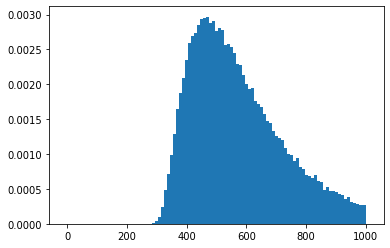

In [ ]:
sub = LinearSubject(onset_e=240, onset_b=0, coef_e=0, coef_b=0, incp_e=0.03, incp_b=0.08, thres=10)
resp = sub.simulate_experiment(np.zeros(100000), np.ones(100000)*1000)
_ = plt.hist(resp[resp>0], density=True, range=(-10, 1010), bins=101)

###Examine the effect of diffusion / drift rate

In [ ]:
import scipy.stats
from scipy.optimize import minimize
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression as LR

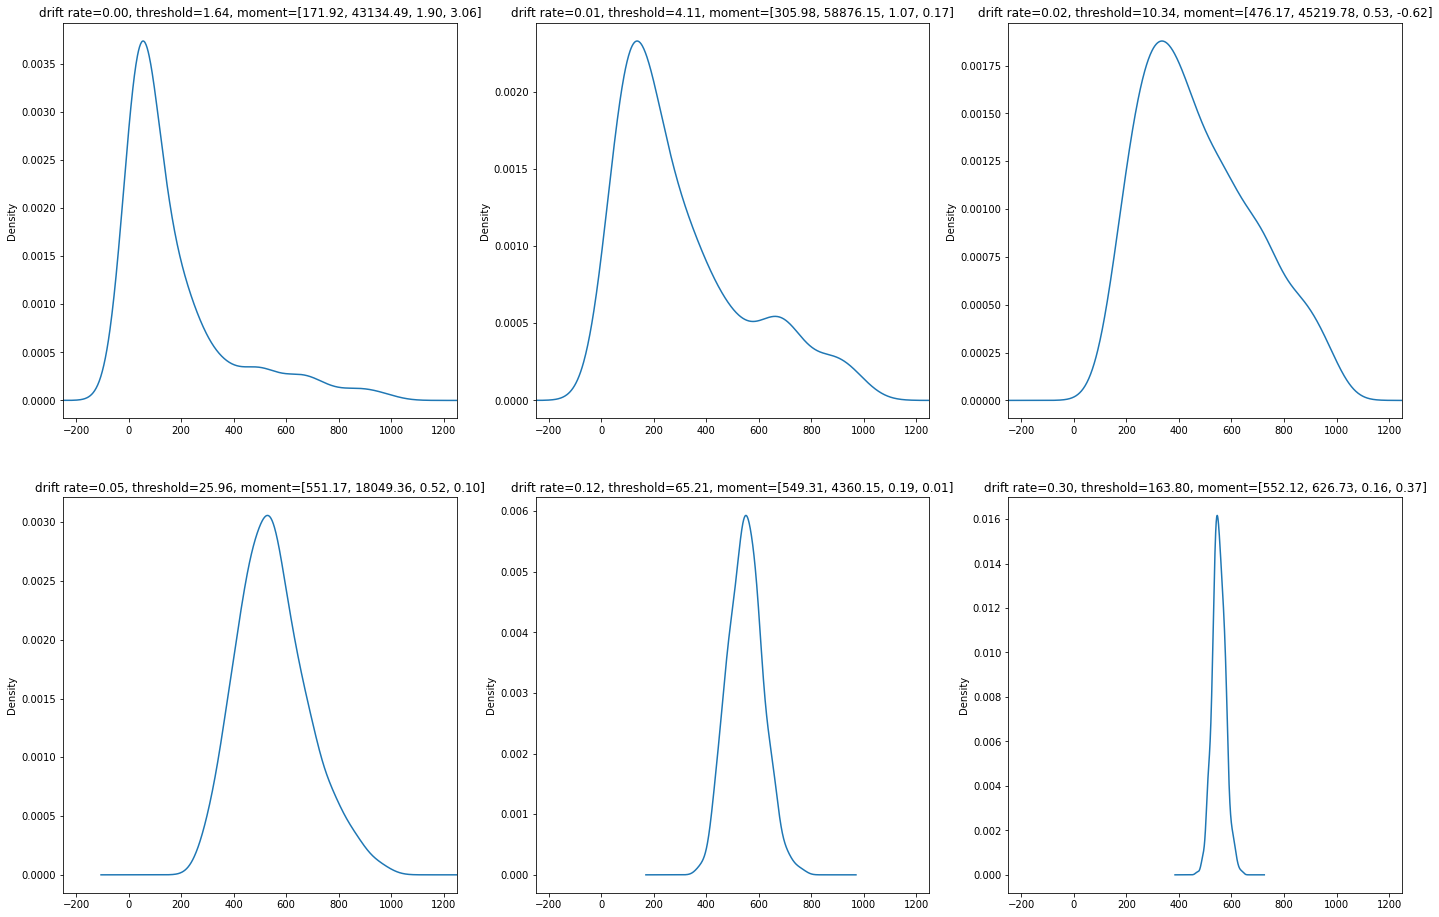

In [ ]:
plt.figure(figsize=(24, 16))
val = np.logspace(1, 3, 6)
init_v = 0.0003
for i in range(6):
  plt.subplot(2,3,i+1)
  args = LinearSubject.EMPTY_ARGS()
  args['incp_e'] = init_v*val[i]
  args['thres'] = 546*init_v*val[i]
  sub = LinearSubject(**args)
  resp = sub.simulate_experiment(np.zeros(480), np.ones(480)*1000)
  resp = resp[resp>0]
  # plt.hist(resp, density=True, range=(-10, 1010), bins=101)
  pd.Series(resp).plot.kde()
  plt.xlim(-250, 1250)
  plt.title(f"drift rate={init_v*val[i]:.2f}, threshold={546*init_v*val[i]:.2f}, moment=[{resp.mean():.2f}, {resp.var():.2f}, {scipy.stats.skew(resp):.2f}, {scipy.stats.kurtosis(resp):.2f}]")

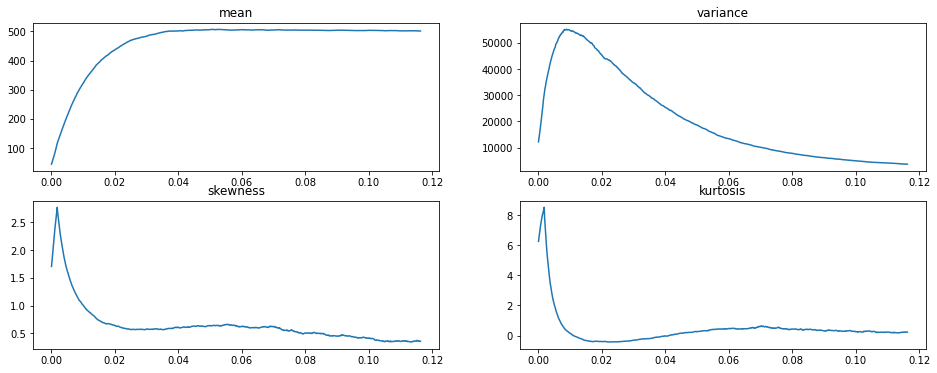

In [ ]:
k=500
nparams=1001
init_v=0.0001
val_grid = init_v * np.linspace(1, 1200, nparams)
resps = np.zeros((1000, nparams))
plt.figure(figsize=(16, 6))
for idx in range(nparams):
  i = val_grid[idx]
  sub = LinearSubject.new_subject(0, 0, i, 0, i, 0, k * i)
  resps[:, idx] = sub.simulate_experiment(np.zeros(1000), np.ones(1000)*1000)

resps[resps==0]=np.nan
plt.subplot(221)
plt.title('mean')
plt.plot(val_grid[:-31], np.convolve(np.nanmean(resps, axis=0), np.ones(31)/31, 'same')[:-31])
plt.subplot(222)
plt.title('variance')
plt.plot(val_grid[:-31], np.convolve(np.nanvar(resps, axis=0), np.ones(31)/31, 'same')[:-31])
plt.subplot(223)
plt.title('skewness')
plt.plot(val_grid[:-31], np.convolve(scipy.stats.skew(resps, axis=0, nan_policy='omit'), np.ones(31)/31, 'same')[:-31])
plt.subplot(224)
plt.title('kurtosis')
plt.plot(val_grid[:-31], np.convolve(scipy.stats.kurtosis(resps, axis=0, nan_policy='omit'), np.ones(31)/31, 'same')[:-31])

###Examine the effect of threshold / drift rate

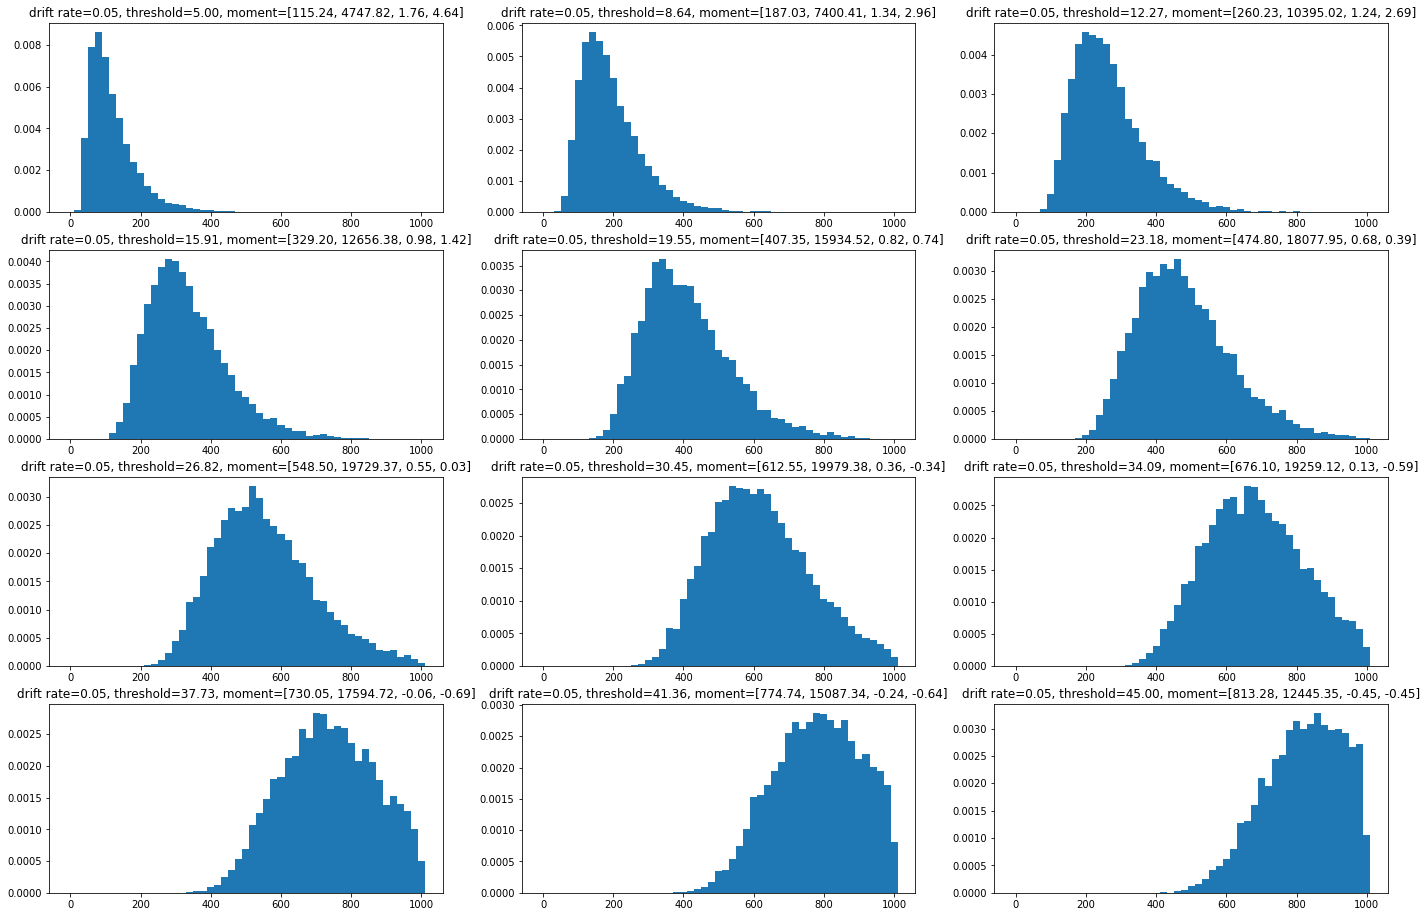

In [ ]:
plt.figure(figsize=(24, 16))
k_val = np.linspace(100, 900, 12)
for i in range(12):
  plt.subplot(4,3,i+1)
  arg = LinearSubject.EMPTY_ARGS()
  arg['incp_e'] = 0.05
  arg['thres'] = 0.05 * k_val[i] 
  sub = LinearSubject(**arg)
  resp = sub.simulate_experiment(np.zeros(10000), np.ones(10000)*1000)
  resp = resp[resp>0]
  plt.hist(resp, density=True, range=(-10, 1010), bins=51)
  plt.title(f"drift rate={0.05:.2f}, threshold={0.05*k_val[i]:.2f}, moment=[{resp.mean():.2f}, {resp.var():.2f}, {scipy.stats.skew(resp):.2f}, {scipy.stats.kurtosis(resp):.2f}]")

In [ ]:
nparams=1001
init_v=0.0001
val_grid = np.linspace(1, 1000, nparams)
resps = np.zeros((1000, nparams))
plt.figure(figsize=(16, 6))
for idx in range(nparams):
  i = val_grid[idx]
  sub = LinearSubject.new_subject(0, 0, 0.05, 0, 0.05, 0, 0.05 * i)
  resps[:, idx] = sub.simulate_experiment(np.zeros(1000), np.ones(1000)*1000)

resps[resps==0]=np.nan
plt.subplot(221)
plt.title('mean')
plt.plot(val_grid[:-31], np.convolve(np.nanmean(resps, axis=0), np.ones(31)/31, 'same')[:-31])
plt.subplot(222)
plt.title('variance')
plt.plot(val_grid[:-31], np.convolve(np.nanvar(resps, axis=0), np.ones(31)/31, 'same')[:-31])
plt.subplot(223)
plt.title('skewness')
plt.plot(val_grid[:-31], np.convolve(scipy.stats.skew(resps, axis=0, nan_policy='omit'), np.ones(31)/31, 'same')[:-31])
plt.subplot(224)
plt.title('kurtosis')
plt.plot(val_grid[:-31], np.convolve(scipy.stats.kurtosis(resps, axis=0, nan_policy='omit'), np.ones(31)/31, 'same')[:-31])

AttributeError: ignored

<Figure size 1152x432 with 0 Axes>

### Combine previous plots together

In [ ]:
valrange = np.linspace(1, 1000, 200)
n_vals = len(valrange)
ve = 0.0001
th = 0.05
mean_grid = np.zeros((n_vals, n_vals))
var_grid = np.zeros((n_vals, n_vals))
# skew_grid = np.zeros((n_vals, n_vals))
# kurt_grid = np.zeros((n_vals, n_vals))
for i in range(n_vals):
  for j in range(n_vals):
    sub = LinearSubject.new_subject(0, 0, ve*valrange[i], 0, ve*valrange[i], 0, th*valrange[j])
    resps = sub.simulate_experiment(np.zeros(1000), np.ones(1000)*1000)
    resps[resps==0]=np.nan
    mean_grid[i, j]=np.nanmean(resps)
    var_grid[i, j]=np.nanvar(resps)
    # skew_grid[i, j]=scipy.stats.skew(resps, nan_policy='omit')
    # kurt_grid[i, j]=scipy.stats.kurtosis(resps, nan_policy='omit')

log_var_grid = np.log(var_grid)
X, Y = np.meshgrid(valrange * ve, valrange * th)

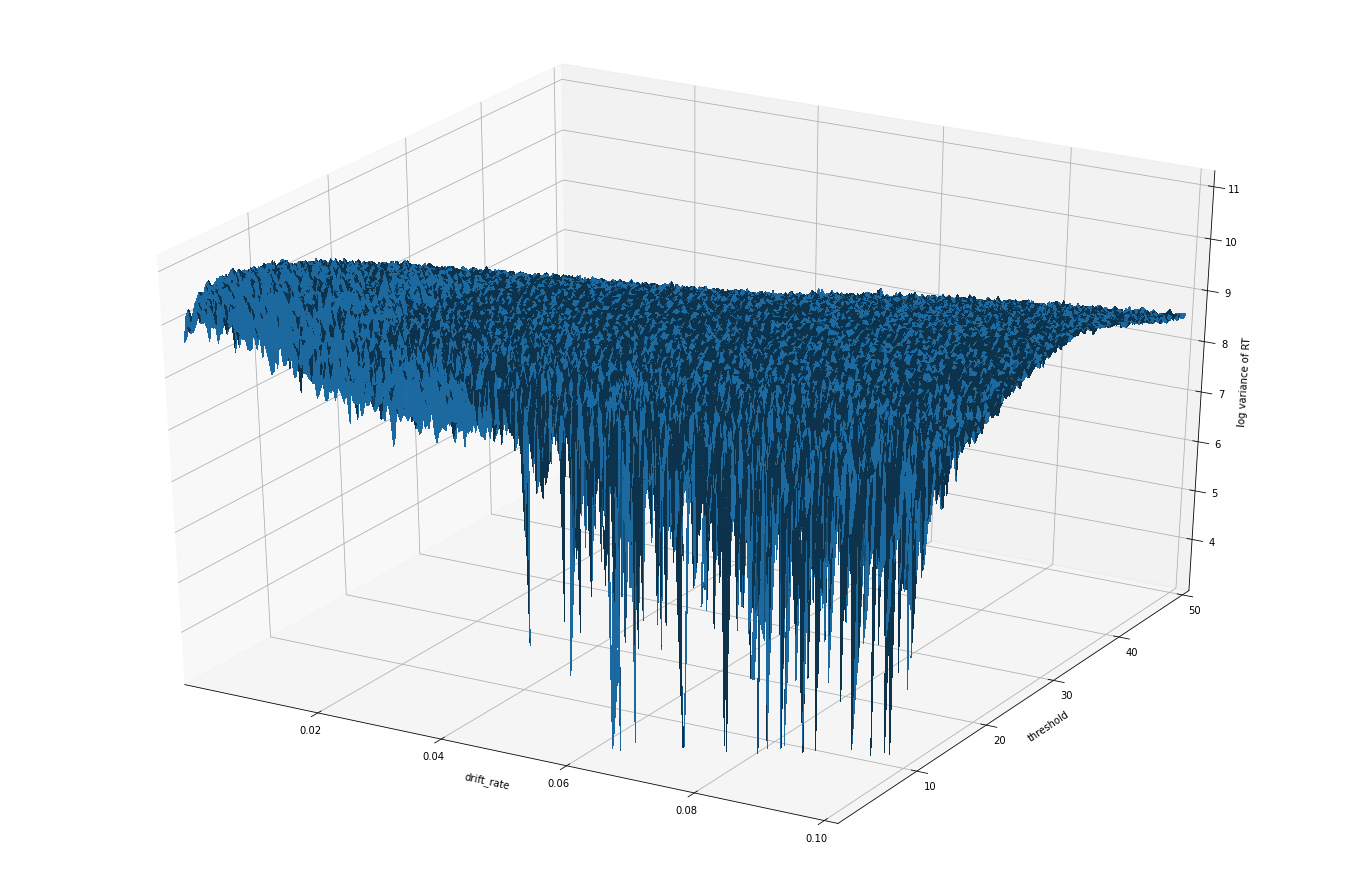

In [ ]:
# %matplotlib notebook
from matplotlib import cm
fig = plt.figure(figsize=(24, 16))
ax = fig.gca(projection="3d")
ax.plot_surface(X, Y, log_var_grid, rstride=1, cstride=1, antialiased=False)
# ax.set_xlim(np.nanmax(X), np.nanmin(X))
ax.set_xlim(np.nanmin(X), np.nanmax(X))
# ax.set_ylim(np.nanmax(Y), np.nanmin(Y))
ax.set_ylim(np.nanmin(Y), np.nanmax(Y))
ax.set_xlabel("drift_rate")
ax.set_ylabel("threshold")
ax.set_zlabel("log variance of RT")
fig.show()

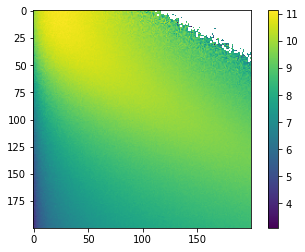

In [ ]:
plt.imshow(log_var_grid)
plt.colorbar()

???????The relation between log variance and drift rate is "CLEARLY" linear

0.9911937733596431
[[-27.25091428]] [11.21321337]


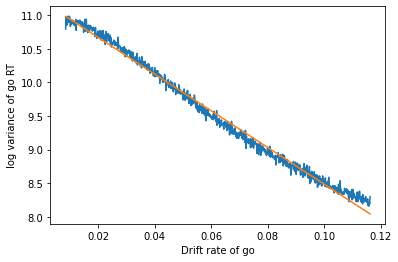

In [ ]:
X = val_grid[50:-31].reshape(-1, 1)
Y = np.log(np.nanvar(resps, axis=0))[50:-31].reshape(-1, 1)
model = LR()
model.fit(X, Y)
pred = model.predict(X)
print(model.score(X, Y))
print(model.coef_, model.intercept_)
plt.xlabel("Drift rate of go")
plt.ylabel("log variance of go RT")
plt.plot(X, Y)
plt.plot(X, pred)

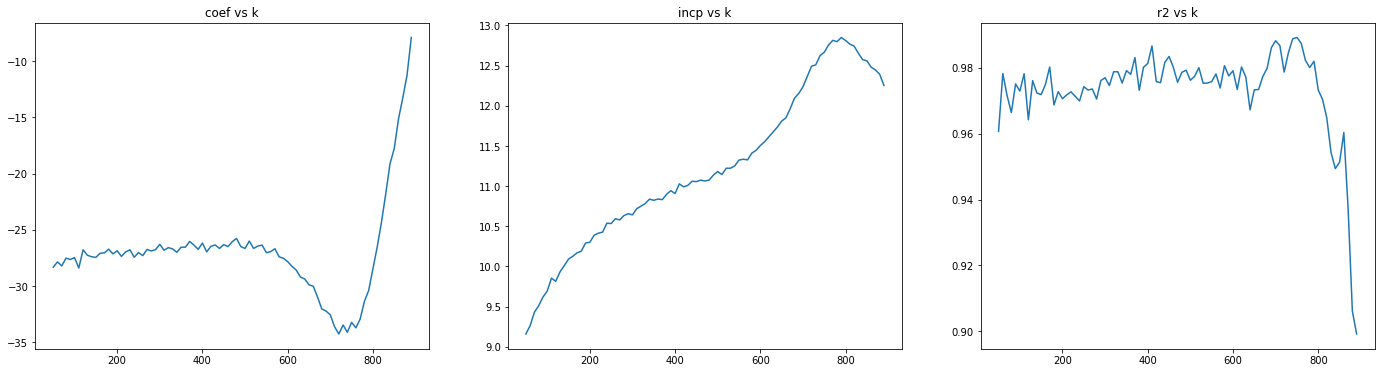

In [ ]:
k_val = np.arange(50, 900, 10)
v_val = np.arange(0.04, 0.12, 0.002)
vars = np.zeros((len(k_val), len(v_val)))
for k in range(len(k_val)):
  for v in range(len(v_val)):
    subj=LinearSubject.new_subject(0, 0, v_val[v], 0, v_val[v], 0, k_val[k] * v_val[v])
    resp=subj.simulate_experiment(np.zeros(1500), np.ones(1500)*1000)
    vars[k, v] = np.nanvar(resp)
coefs=np.zeros_like(k_val, 'float')
incps=np.zeros_like(k_val, 'float')
r2=np.zeros_like(k_val, 'float')
for i in range(len(k_val)):
  model=LR()
  model.fit(v_val.reshape(-1, 1), np.log(vars[i]).reshape(-1, 1))
  coefs[i]=model.coef_
  incps[i]=model.intercept_
  r2[i]=model.score(v_val.reshape(-1,1), np.log(vars[i]).reshape(-1,1))
plt.figure(figsize=(24, 6))
plt.subplot(1,3,1)
plt.title('coef vs k')
plt.plot(k_val, coefs)
plt.subplot(1,3,2)
plt.title('incp vs k')
plt.plot(k_val, incps)
plt.subplot(1,3,3)
plt.title('r2 vs k')
plt.plot(k_val, r2)

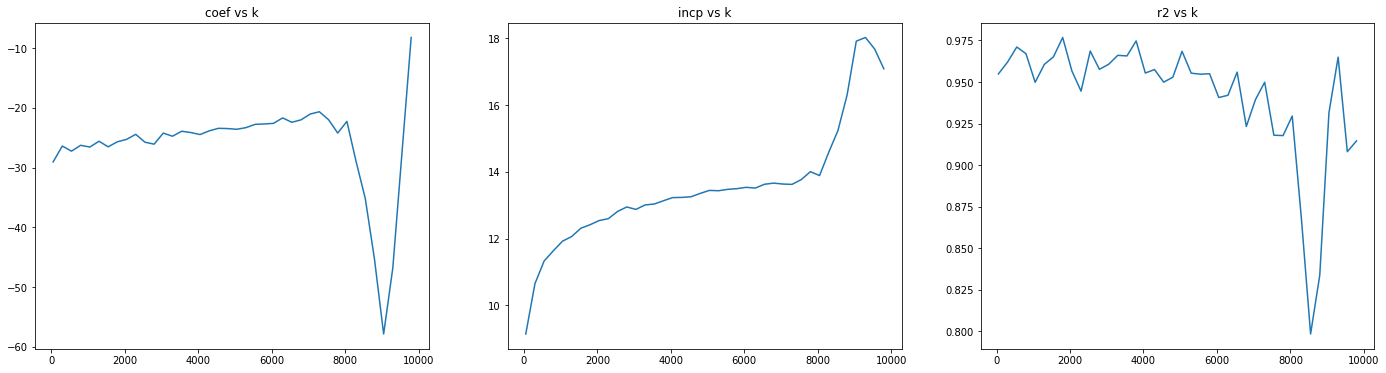

In [ ]:
k_val = np.arange(50, 10000, 250)
v_val = np.arange(0.04, 0.12, 0.005)
vars = np.zeros((len(k_val), len(v_val)))
for k in range(len(k_val)):
  for v in range(len(v_val)):
    subj=LinearSubject.new_subject(0, 0, v_val[v], 0, v_val[v], 0, k_val[k] * v_val[v])
    resp=subj.simulate_experiment(np.zeros(500), np.ones(500)*10000)
    vars[k, v] = np.nanvar(resp)
coefs=np.zeros_like(k_val, 'float')
incps=np.zeros_like(k_val, 'float')
r2=np.zeros_like(k_val, 'float')
for i in range(len(k_val)):
  model=LR()
  model.fit(v_val.reshape(-1, 1), np.log(vars[i]).reshape(-1, 1))
  coefs[i]=model.coef_
  incps[i]=model.intercept_
  r2[i]=model.score(v_val.reshape(-1,1), np.log(vars[i]).reshape(-1,1))
plt.figure(figsize=(24, 6))
plt.subplot(1,3,1)
plt.title('coef vs k')
plt.plot(k_val, coefs)
plt.subplot(1,3,2)
plt.title('incp vs k')
plt.plot(k_val, incps)
plt.subplot(1,3,3)
plt.title('r2 vs k')
plt.plot(k_val, r2)

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def slideplot(v_e, thres):
  fig = plt.figure(figsize=(24, 8))
  ax = fig.add_subplot(2,2,1)
  ax.set_title(f"log var RT with threshold={valrange[thres-1]*th}")
  ax.plot(ve*valrange, log_var_grid[:, thres-1])
  ax = fig.add_subplot(2,2,2)
  ax.set_title(f"log var RT with driftrate={valrange[v_e-1]*ve}")
  ax.plot(th*valrange, log_var_grid[v_e-1, :])
  ax = fig.add_subplot(2,2,3)
  ax.set_title(f"mean RT with threshold={valrange[thres-1]*th}")
  ax.plot(ve*valrange, mean_grid[:, thres-1])
  ax = fig.add_subplot(2,2,4)
  ax.set_title(f"mean RT with driftrate={valrange[v_e-1]*ve}")
  ax.plot(th*valrange, mean_grid[v_e-1, :])
interact(slideplot, v_e=widgets.IntSlider(min=1, max=200, step=1), thres=widgets.IntSlider(min=1, max=200, step=1));

In [ ]:
fig = plt.figure(figsize=(24, 16))
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.plot_surface(X, Y, mean_grid, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax = fig.add_subplot(2, 2, 4, projection='3d')

Execute hit at 72


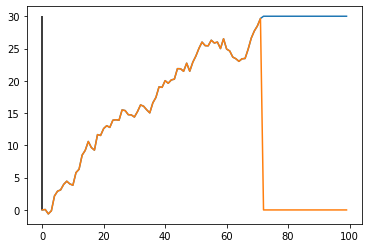

720

In [ ]:
subject.plot_trial(0, 1000)

In [ ]:
# subject.trial_no_update(0, 1000)
expenv = SimpleExperimentEnvironment(subject)
data = expenv.auto_repeat(1)

In [ ]:
df = data.to_pandas()
"p_all, p_stop, p_go, medianGoRT, meanSSD, medianSSRT, nthSSRT"
compute_SSRT(df)

(0.7895833333333333,
 0.0,
 1.0,
 90.0,
 51.48514851485149,
 38.51485148514851,
 18.51485148514851)

In [ ]:
df[df['trial_type']==1].describe()

,subject_id,length,ssd,trial_type,stim_direction,response,resp_direction,outcome
count,370.0,370.0,370.0,370.0,370.0,370.000000,370.0,370.0
mean,0.0,1000.0,0.0,1.0,0.0,72.162162,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,26.660074,0.0,0.0
min,0.0,1000.0,0.0,1.0,0.0,20.000000,0.0,0.0
25%,0.0,1000.0,0.0,1.0,0.0,50.000000,0.0,0.0
50%,0.0,1000.0,0.0,1.0,0.0,70.000000,0.0,0.0
75%,0.0,1000.0,0.0,1.0,0.0,90.000000,0.0,0.0
max,0.0,1000.0,0.0,1.0,0.0,170.000000,0.0,0.0


In [ ]:
df[df['trial_type']==0]

,subject_id,length,ssd,trial_type,stim_direction,response,resp_direction,outcome
3,0.0,1000.0,801.703925,0.0,0.0,90.0,0.0,1.0
7,0.0,1000.0,50.000000,0.0,0.0,80.0,0.0,1.0
21,0.0,1000.0,307.355604,0.0,0.0,70.0,0.0,1.0
28,0.0,1000.0,50.000000,0.0,0.0,100.0,0.0,1.0
30,0.0,1000.0,397.797353,0.0,0.0,90.0,0.0,1.0
...,...,...,...,...,...,...,...,...
455,0.0,1000.0,814.232508,0.0,0.0,70.0,0.0,1.0
457,0.0,1000.0,50.000000,0.0,0.0,120.0,0.0,1.0
458,0.0,1000.0,205.320478,0.0,0.0,40.0,0.0,1.0
459,0.0,1000.0,50.000000,0.0,0.0,40.0,0.0,1.0


## Simulate the effect of each parameter

In [ ]:
_ = run_manipulated_param_experiments(man_pos=0, man_value_grid=np.linspace(-0.5, 0.5, num=51), fixed_value=[-0.04, 0.09, 0.05, 0.01, 29], nexp=1)

In [ ]:
default_value = np.array([-0.5, 0.2, 0.12, 0.1, 30])
nexp=5
param_resol=11
kes=np.linspace(-1, 1, param_resol)
kbs=np.linspace(-20, 1000, param_resol)
bes=np.linspace(0.05, 0.2, param_resol)
bbs=np.linspace(-0.1, 0.5, param_resol)
ths=np.linspace(0,40,param_resol)

###Imagen adaptive (notice stair effect)

In [ ]:
kes_summary = run_manipulated_param_experiments(man_pos=0, man_value_grid=kes, fixed_value=default_value, nexp=nexp)
plot_summary_vs_params(df=kes_summary, param_name='ke', ci=95)

kb can influence prob of correct in go trial due to repeating experiment when respond too quick, and subject will perceive a go trial if the stop signal presents after action time.

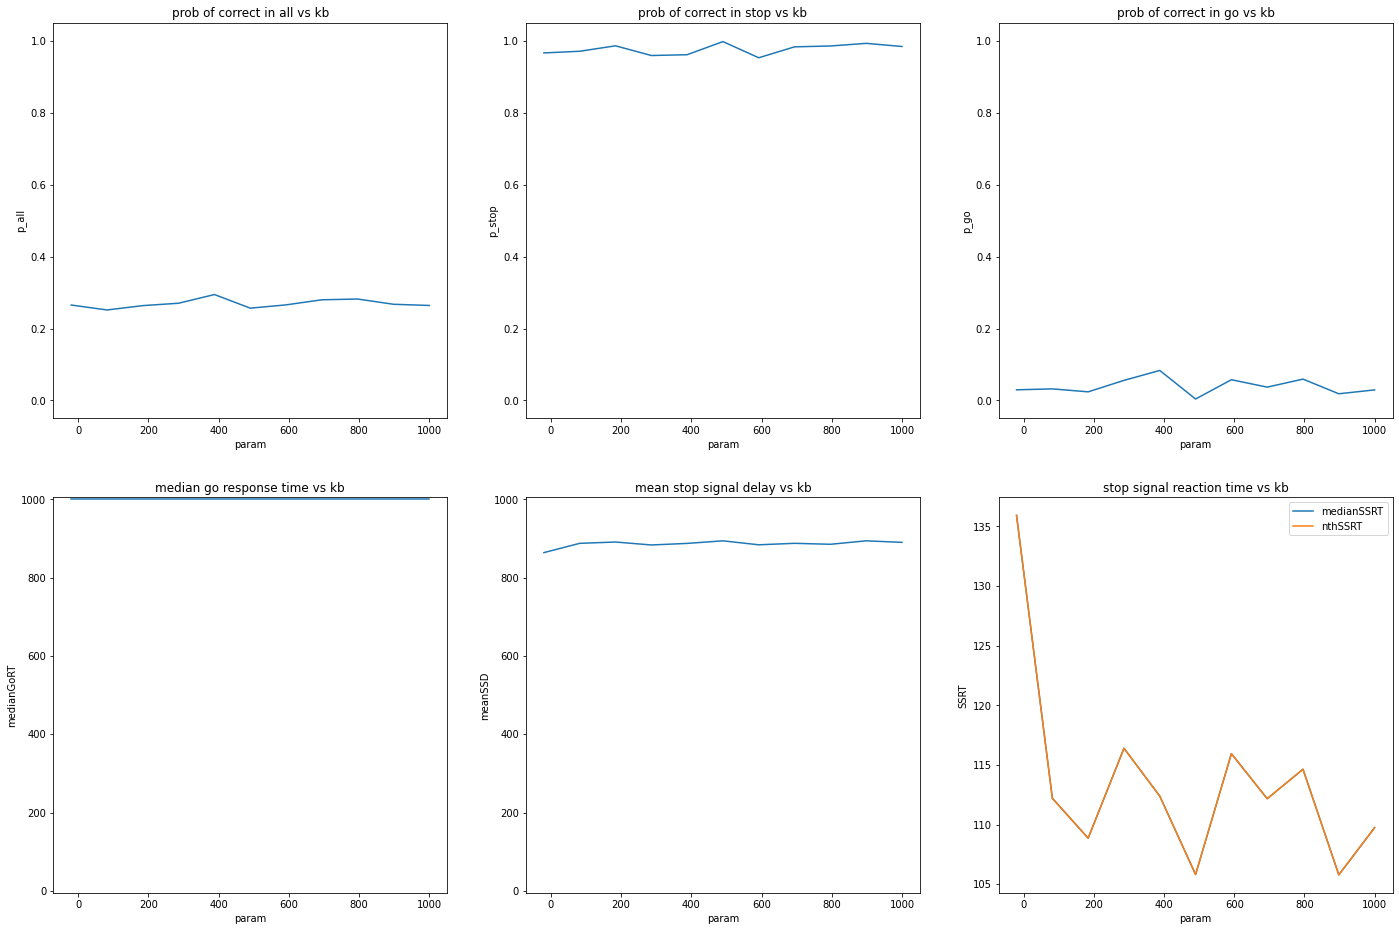

In [ ]:
kbs_summary = run_manipulated_param_experiments(man_pos=1, man_value_grid=kbs, fixed_value=default_value, nexp=nexp)
plot_summary_vs_params(df=kbs_summary, param_name='kb', ci=90)

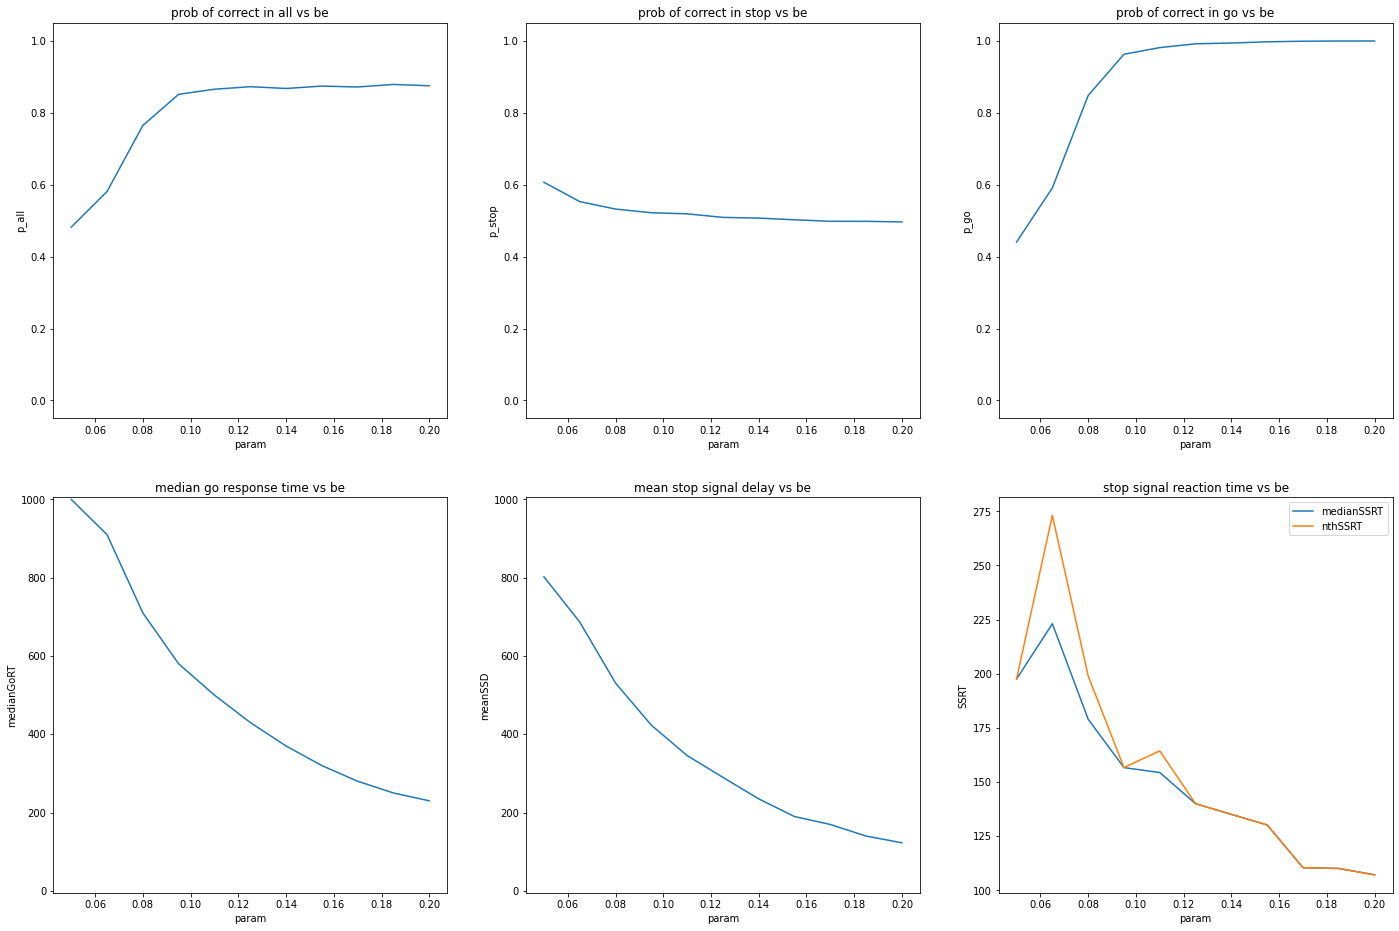

In [ ]:
bes_summary = run_manipulated_param_experiments(man_pos=2, man_value_grid=bes, fixed_value=default_value, nexp=nexp)
plot_summary_vs_params(df=bes_summary, param_name='be', ci=90)

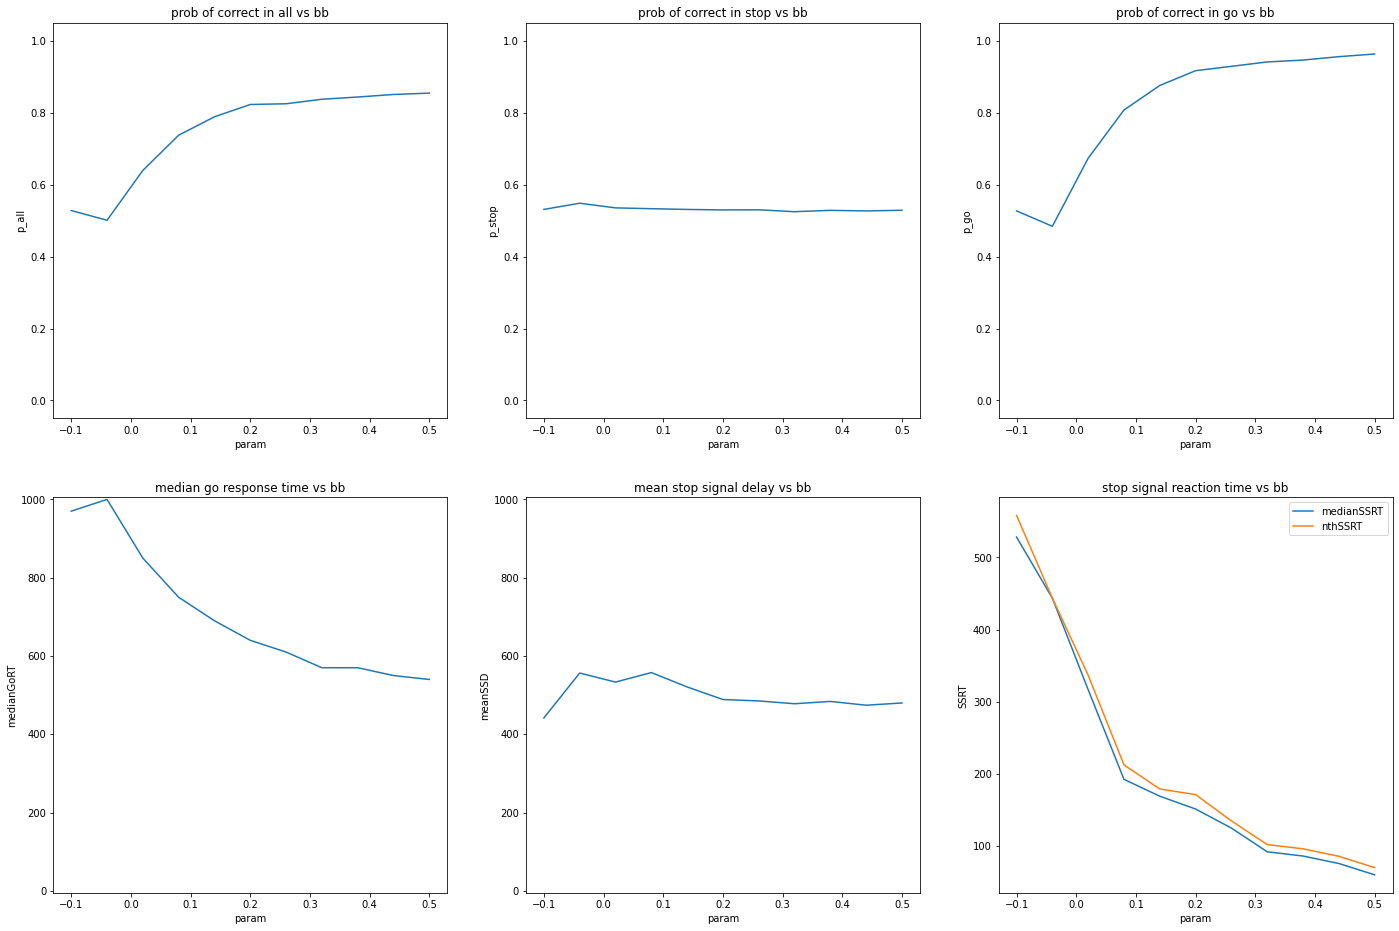

In [ ]:
bbs_summary = run_manipulated_param_experiments(man_pos=3, man_value_grid=bbs, fixed_value=default_value, nexp=nexp)
plot_summary_vs_params(df=bbs_summary, param_name='bb', ci=95)

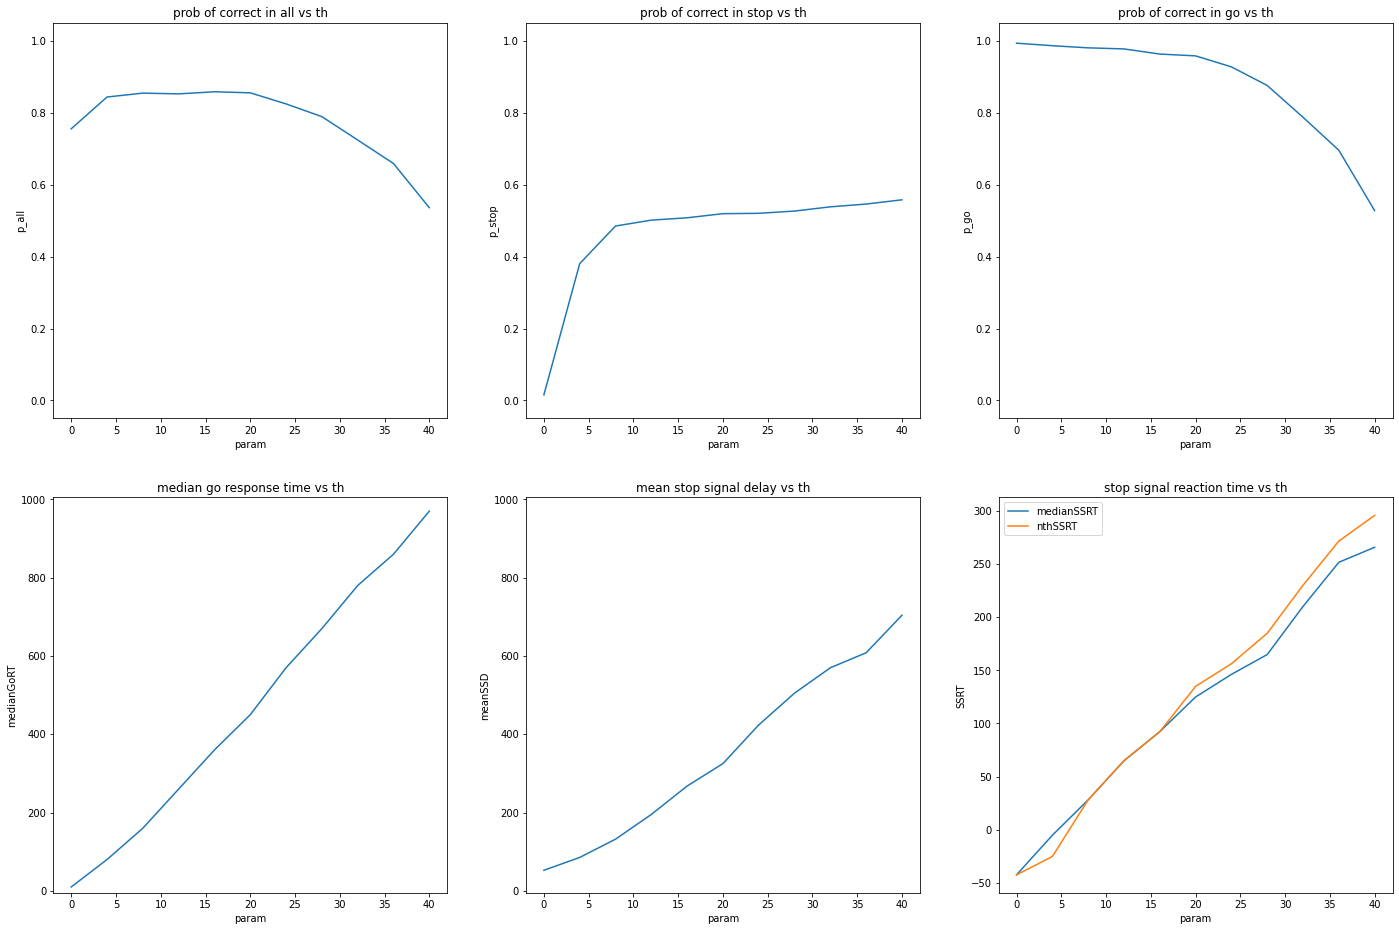

In [ ]:
ths_summary = run_manipulated_param_experiments(man_pos=4, man_value_grid=ths, fixed_value=default_value, nexp=nexp)
plot_summary_vs_params(df=ths_summary, param_name='th', ci=90)

###Random simulation

In [ ]:
ssd_provider = RandomProvider()
# ssds = []
# for _ in range(10000):
#   ssd = ssd_provider.provide()
#   ssd_provider.update(np.random.normal(ssd, 50))
#   ssds.append(ssd)
# plt.plot(np.array(ssds).cumsum()/np.arange(10000))

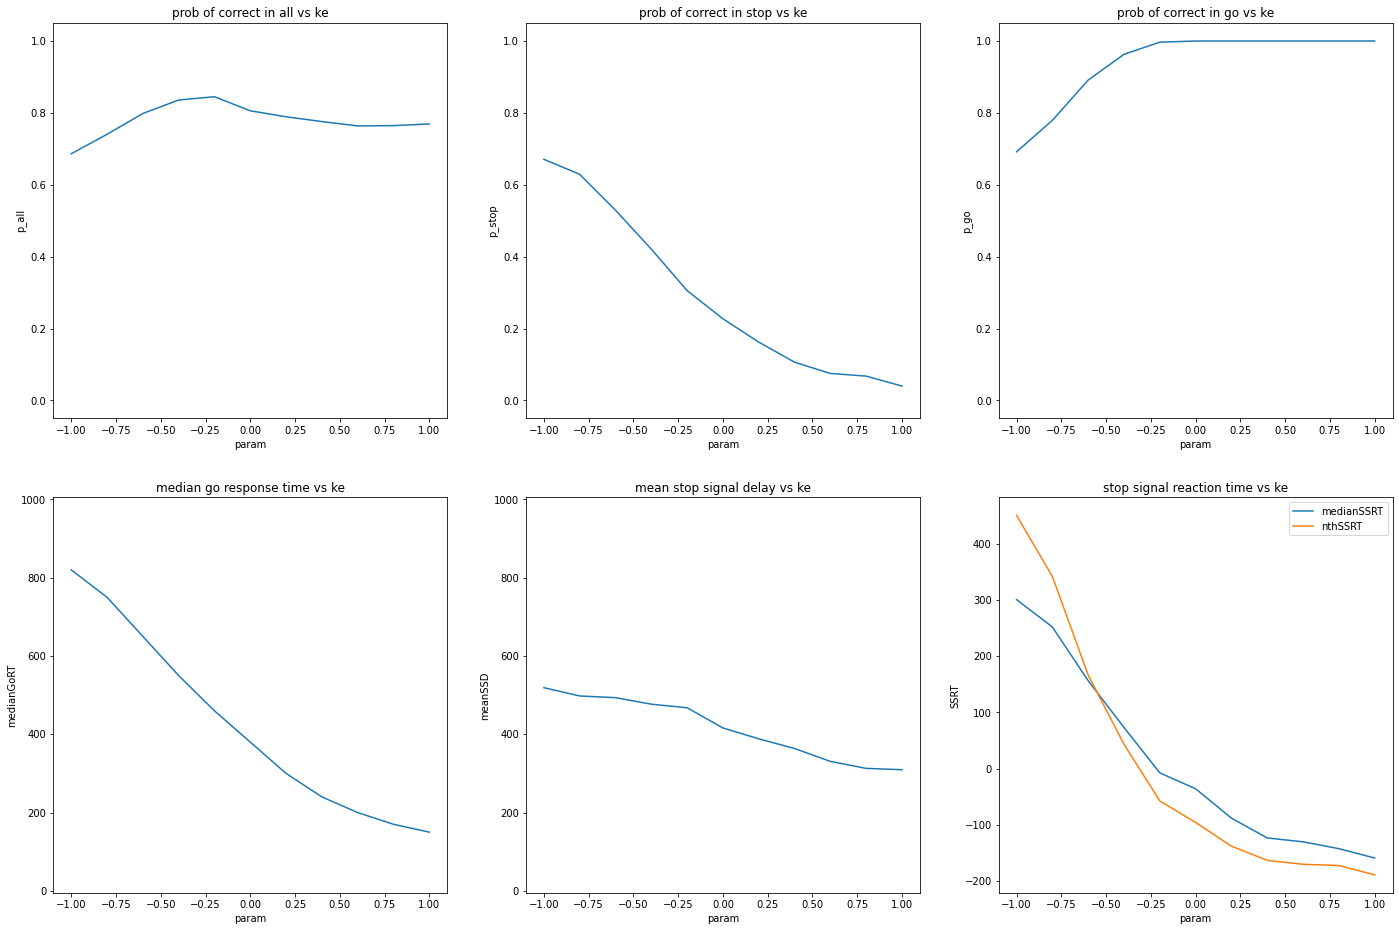

In [ ]:
kes_summary = run_manipulated_param_experiments(man_pos=0, man_value_grid=kes, fixed_value=default_value, nexp=nexp, ssd_type = ssd_provider)
plot_summary_vs_params(df=kes_summary, param_name='ke', ci=90)

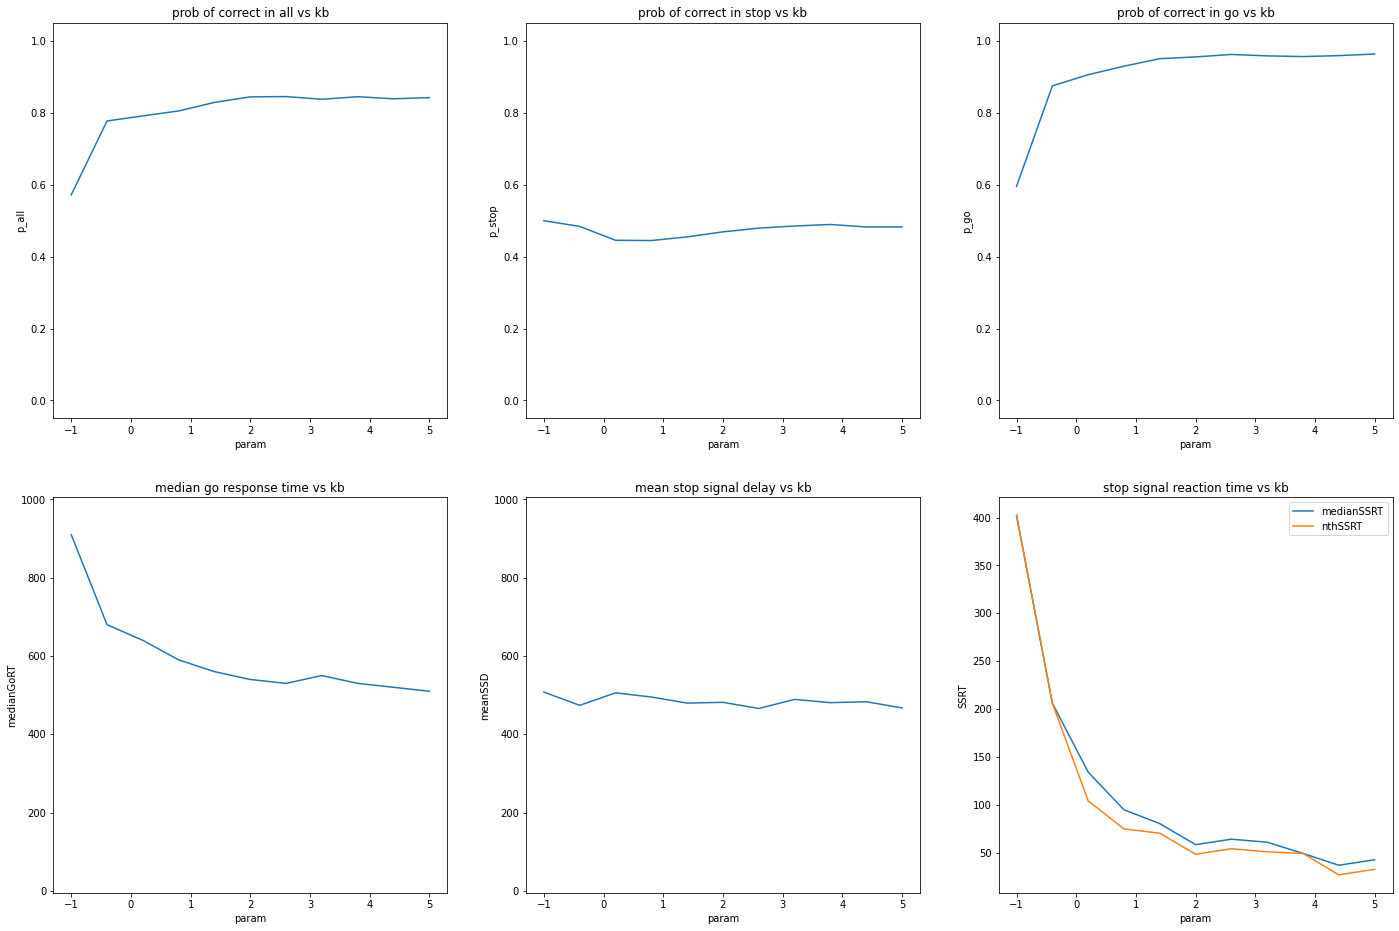

In [ ]:
kbs_summary = run_manipulated_param_experiments(man_pos=1, man_value_grid=kbs, fixed_value=default_value, nexp=nexp, ssd_type = ssd_provider)
plot_summary_vs_params(df=kbs_summary, param_name='kb', ci=90)

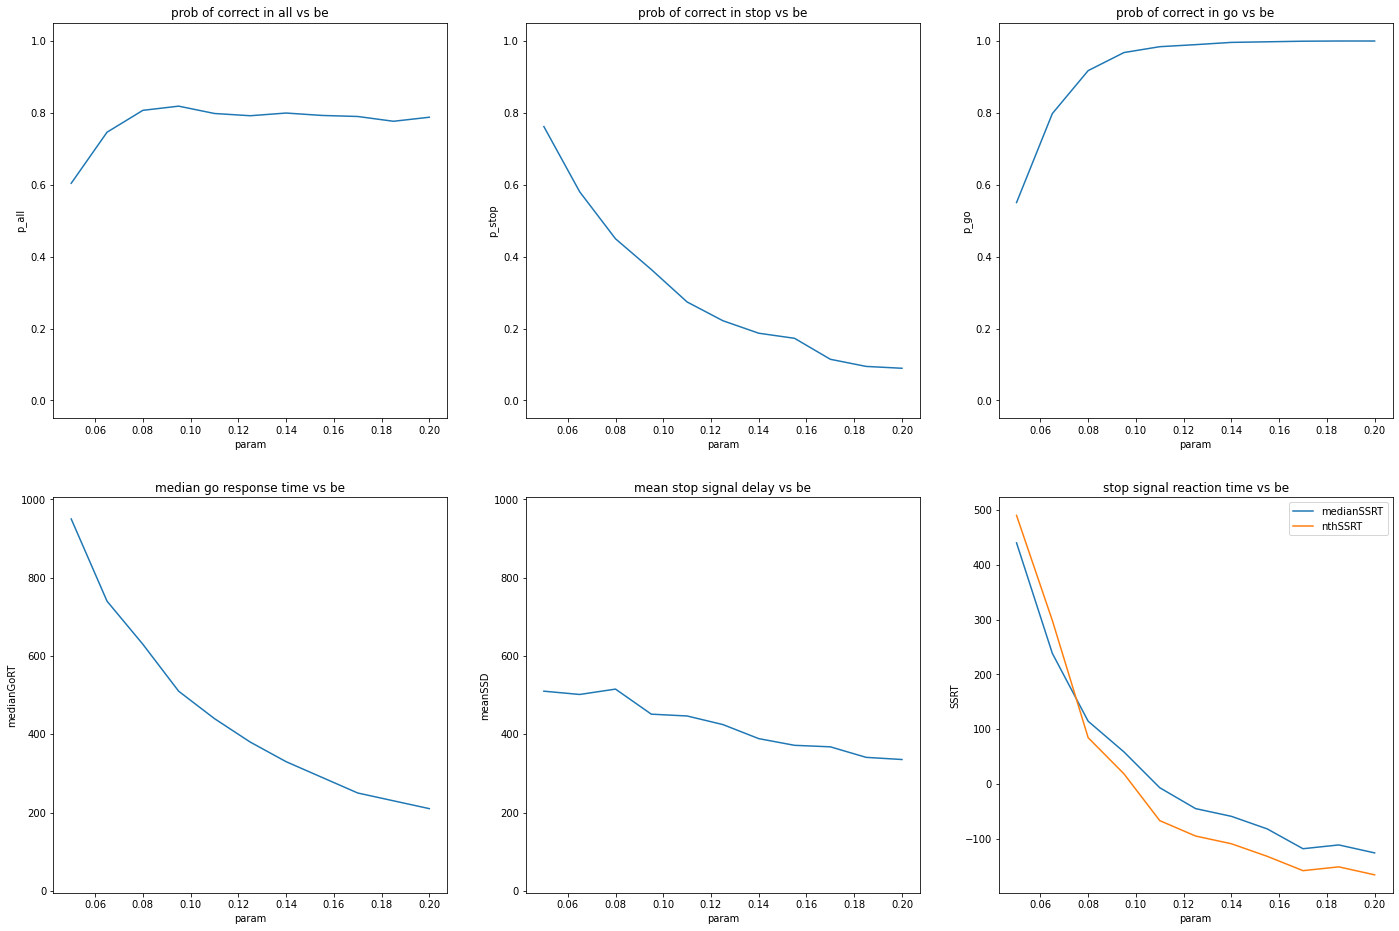

In [ ]:
bes_summary = run_manipulated_param_experiments(man_pos=2, man_value_grid=bes, fixed_value=default_value, nexp=nexp, ssd_type = ssd_provider)
plot_summary_vs_params(df=bes_summary, param_name='be', ci=90)

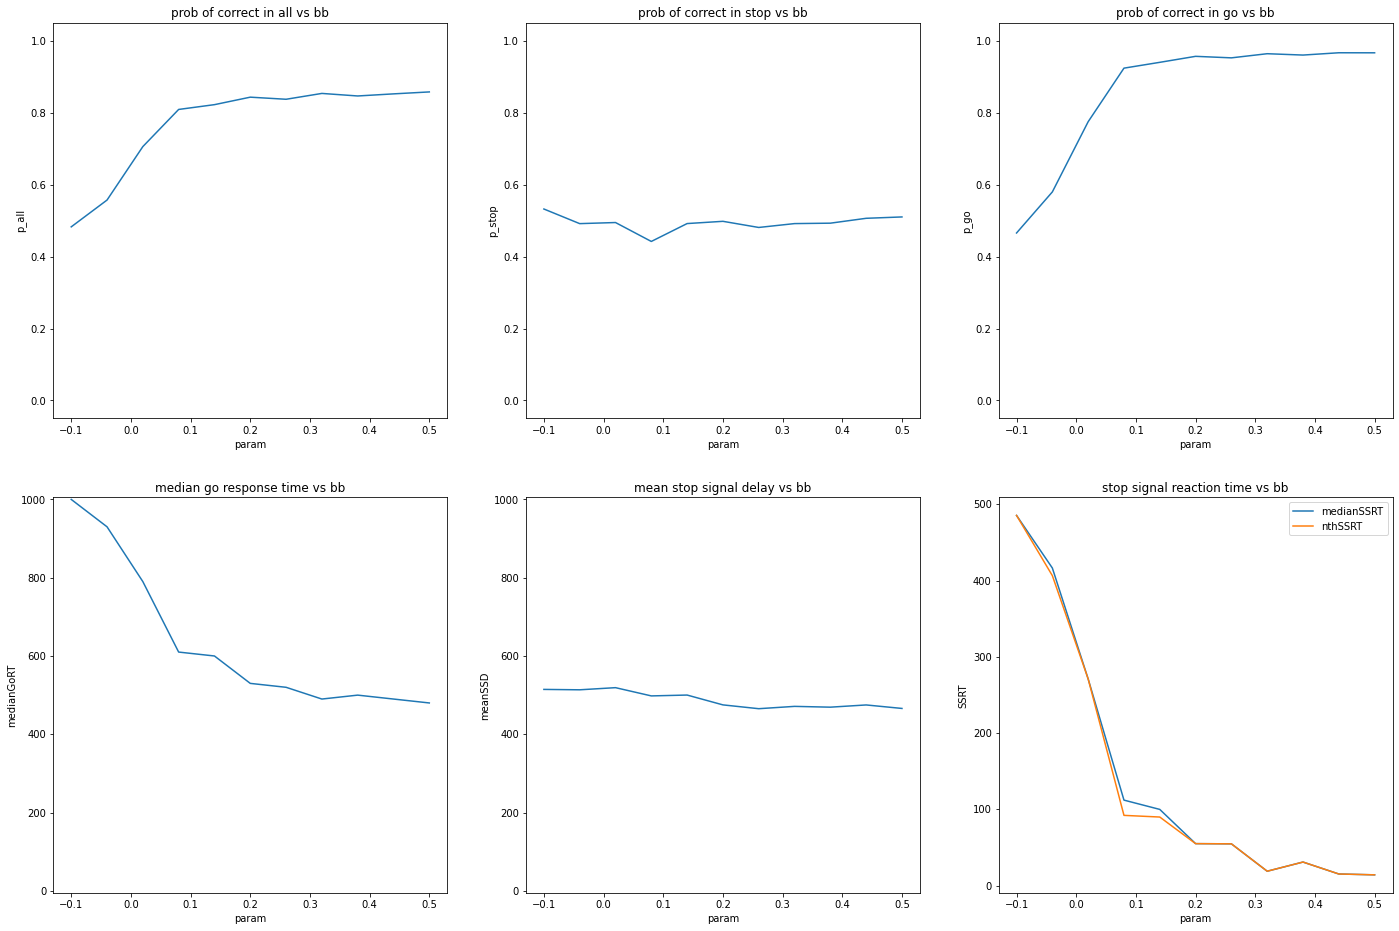

In [ ]:
bbs_summary = run_manipulated_param_experiments(man_pos=3, man_value_grid=bbs, fixed_value=default_value, nexp=nexp, ssd_type = ssd_provider)
plot_summary_vs_params(df=bbs_summary, param_name='bb', ci=90)

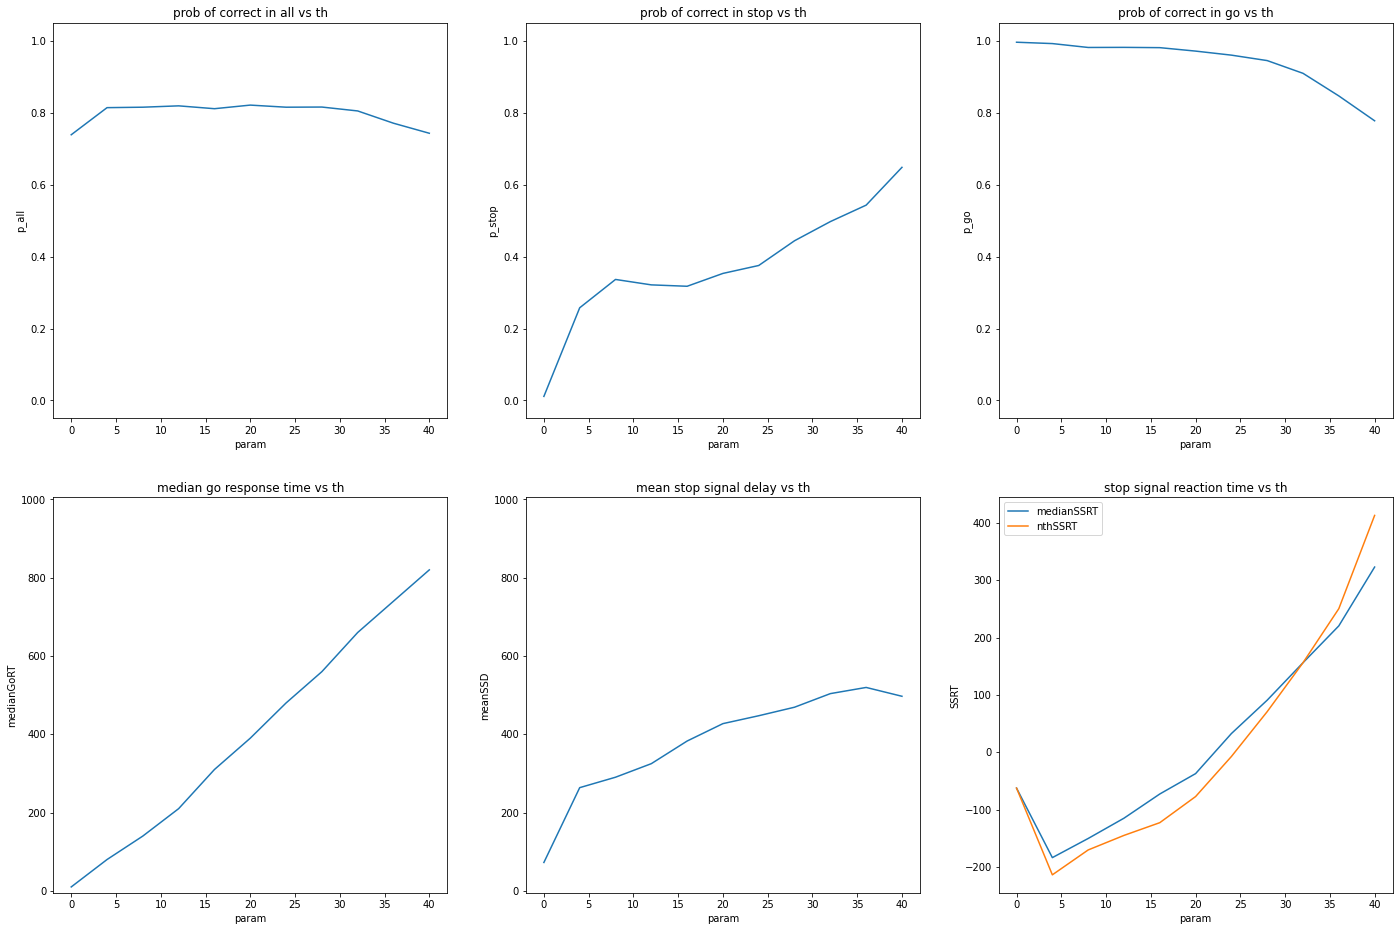

In [ ]:
ths_summary = run_manipulated_param_experiments(man_pos=4, man_value_grid=ths, fixed_value=default_value, nexp=nexp, ssd_type = ssd_provider)
plot_summary_vs_params(df=ths_summary, param_name='th', ci=90)

In [ ]:
# Just for "run cells before" in convenience

## performance test

Processed dataframe with qc and weights.
Num of subjects: 1138, attributes:Index(['subject_id', 'length', 'ssd', 'trial_type', 'stim_direction',
       'response', 'resp_direction', 'outcome'],
      dtype='object')


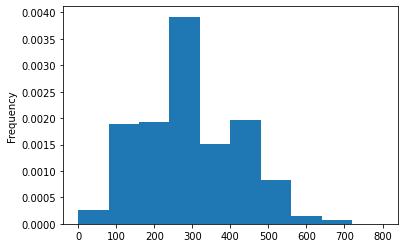

In [ ]:
params = np.array([200, -0.1, 0.1, 0.1, 0.1, 0])
full_data = []
subj_params = []
for i in range(2000):
  subj = params*np.random.rand(6)
  subj[5] = subj[3] * 1000 * np.random.uniform(0.1, 0.9)
  subj_params.append(subj)
  subj = LinearSubject.new_subject(subj[0], 0, subj[1],subj[2],subj[3],subj[4],subj[5])
  data = SimpleExperimentEnvironment(subj, IMAGENSSDProvider()).start()
  data.data['subject_id'] = float(i)
  full_data.append(data.to_pandas())

full_sim_df = pd.concat(full_data, ignore_index=True)
SIM_proc.initialize_class(full_sim_df, qc=SIM_proc.sim_default_qc, weight_quantiles=np.arange(0.1, 1, 0.1))
SIM_proc.SIM_df[SIM_proc.SIM_df['trial_type']==0]['ssd'].plot.hist(density=True)
SIM_params = pd.DataFrame(subj_params)
SIM_params = SIM_params.drop(index=SIM_params.index[~SIM_params.index.isin(SIM_proc.subjects)])

In [ ]:
SIM_proc.raw_weights

{'var_RT_c': array([29313.43424625, 31771.07268942, 33492.4069244 , 34711.98276815,
        35827.22895902, 36681.7135356 , 37245.45450811, 37216.2398961 ,
        36160.72945166]),
 'var_RT_e': array([26235.83855143, 28278.85756777, 29733.494411  , 31190.4184908 ,
        32348.01728744, 33438.78341122, 34633.61857667, 35794.46679495,
        37310.96739879]),
 'var_p_go': 0.0,
 'var_p_stop': {0: 0.005029111713629483,
  50: 0.011127304743365938,
  100: 0.02056044337867264,
  150: 0.030095601356863556,
  200: 0.06417155222792241,
  250: 0.08777263252379404,
  300: 0.10175230192974556,
  350: 0.10087347788392412,
  400: 0.09214684168673229,
  450: 0.08765435803710246,
  500: 0.09115489632724592,
  550: 0.08930912250120335,
  600: 0.09623899207799289,
  650: 0.10348324557192866,
  700: 0.1184670561963505,
  750: 0.16759002770083106,
  800: 0.0}}

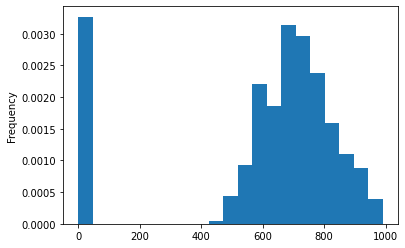

In [ ]:
SIM_proc.extract_subject_df(15)['response'].plot.hist(bins=21, density=True)

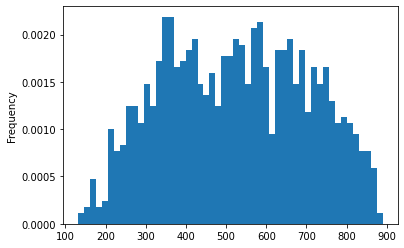

In [ ]:
test_df = SIM_proc.SIM_df
test_df = test_df.drop(index=test_df.index[(test_df['trial_type']<1) | (test_df['response']==0)])
test_df.groupby('subject_id').mean()['response'].plot.hist(density=True, bins=51)

In [ ]:
!pip install line_profiler
%load_ext line_profiler

     |████████████████████████████████| 63 kB 1.6 MB/s 


In [ ]:
aly = SIM_proc.get_analyzer(26, np.arange(0.1, 1, 0.1), True, 7)

[350 400 300 450 250 200 150]


In [ ]:
aly.analyze()

{'mean_go': 603.2835820895523,
 'mean_ssd': 348.780487804878,
 'medianssrt': 251.21951219512198,
 'nthssrt': 301.219512195122,
 'onset_e_init': 90.0,
 'p_go': 0.938375350140056,
 'p_stop': 0.5772357723577236,
 'pass_qc': True,
 'std_go': 168.5600832663259,
 'thres_init': 12.753650804827032,
 'v_e_init': 0.0248471824345278}

In [ ]:
import scipy.stats
from scipy.optimize import minimize
from sklearn.neighbors import KernelDensity

In [ ]:
SIM_params.head()

,0,1,2,3,4,5
0,9.367452,-0.029700,0.087882,0.063140,0.059336,25.674675
1,108.047268,-0.033388,0.027417,0.082310,0.099832,20.633257
2,73.991784,-0.098700,0.002797,0.095172,0.098694,63.015488
3,57.975547,-0.014513,0.052003,0.057615,0.088217,7.747885
4,138.248879,-0.090796,0.009297,0.098878,0.015586,44.707999


In [ ]:
from scipy.stats import entropy

def build_subject(param):
  args = LinearSubject.EMPTY_ARGS()
  args['onset_e'] = param[0]
  args['incp_e'] = param[1]
  args['thres'] = param[2]
  subj = LinearSubject(**args)
  return subj

def eval_and_return_loss(param, loss_func):
  subj = build_subject(param)
  resp = subj.simulate_experiment(np.zeros(480), np.ones(480)*1000)
  resp = resp[resp>0]
  return loss_func(resp, aly.go_RT.to_numpy())

def entropy_loss_func(dist, target):
  return entropy(np.histogram(dist, bins=21, range=(0, 1000), density=True)[0], np.histogram(target, bins=21, range=(0, 1000), density=True)[0])

def mean_loss_func(dist, target):
  return np.square(np.mean(dist)-np.mean(target))

onset = np.quantile(aly.go_RT, 0.1) - aly.analyze_result['std_go']
inite = (11-np.log(np.nanvar(aly.go_RT)))/30
thres = inite * (aly.go_RT.mean()-onset)
result = minimize(eval_and_return_loss, [onset, inite, thres], args=(mean_loss_func), method='Nelder-Mead', options={'maxiter': 1000, 'ftol': 1e-3})
result = minimize(eval_and_return_loss, result.x, args=(entropy_loss_func), method='Nelder-Mead', options={'maxiter':1000, 'ftol': 1e-3})

In [ ]:
result

 final_simplex: (array([[226.73404103,   0.02235732,  10.35038938],
       [226.73404103,   0.02235732,  10.35038938],
       [226.73404103,   0.02235732,  10.35038938],
       [226.73404103,   0.02235732,  10.35038938]]), array([0.02410478, 0.04119866, 0.05300722, 0.06983179]))
           fun: 0.02410478072817735
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 2667
           nit: 1000
        status: 2
       success: False
             x: array([226.73404103,   0.02235732,  10.35038938])

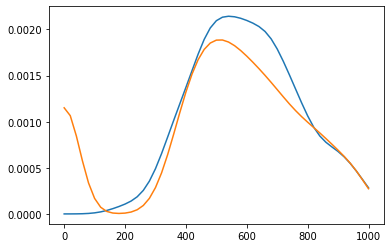

In [ ]:
x = np.linspace(0, 1000, 51)
resp = build_subject(result.x).simulate_experiment(np.zeros(4800), np.ones(4800)*1000)
kde1 = KernelDensity(kernel='gaussian', bandwidth=51).fit(resp.reshape(-1, 1))
dens1 = np.exp(kde1.score_samples(x.reshape(-1, 1)))
kde2 = KernelDensity(kernel='gaussian', bandwidth=51).fit(aly.go_RT.to_numpy().reshape(-1, 1))
dens2 = np.exp(kde2.score_samples(x.reshape(-1, 1)))
plt.plot(x, dens2)
plt.plot(x, dens1)

In [ ]:
solver = SSTSolver(aly, n_exps=5)
solver.param_range

array([[ 64.79355496, 115.03977836],
       [ -0.01616403,   0.        ],
       [  0.        ,   0.02466347],
       [  0.01293122,   0.03443873],
       [  0.01111291,   0.02959616],
       [  8.07378262,  21.5022813 ]])

In [ ]:
SIM_params.iloc[26]

0    24.369792
1    -0.040521
2     0.033355
3     0.042467
4     0.048307
5    22.605259
Name: 45, dtype: float64

In [ ]:
%prun solver.solve(n_init=40, n_iters=100)

1/40 is starting. Initial value: [66.60160101 -0.00598403  0.01226307  0.02880703  0.02011128 20.17200693].
     fun: 0.05475216312173546
     jac: array([-3477392.60457711, -2213477.4956111 , -1506386.89699401,
        -873024.16316012, -1075795.48028833, -2485078.86448321])
 message: 'Linear search failed'
    nfev: 20
     nit: 1
  status: 4
 success: False
       x: array([ 0.        ,  0.        ,  0.03858772,  0.02942878,  0.02651183,
       20.04801621])
 final_simplex: (array([[ 0.000125  ,  0.        ,  0.03858772,  0.02942878,  0.02651182,
        20.54921447],
       [ 0.000125  ,  0.        ,  0.03858772,  0.02942878,  0.02651182,
        20.54921445],
       [ 0.000125  ,  0.        ,  0.03858772,  0.02942878,  0.02651182,
        20.54921446],
       [ 0.000125  ,  0.        ,  0.03858772,  0.02942878,  0.02651182,
        20.54921445],
       [ 0.000125  ,  0.        ,  0.03858772,  0.02942878,  0.02651182,
        20.54921446],
       [ 0.000125  ,  0.        ,  0.03858

In [ ]:
solver.loss

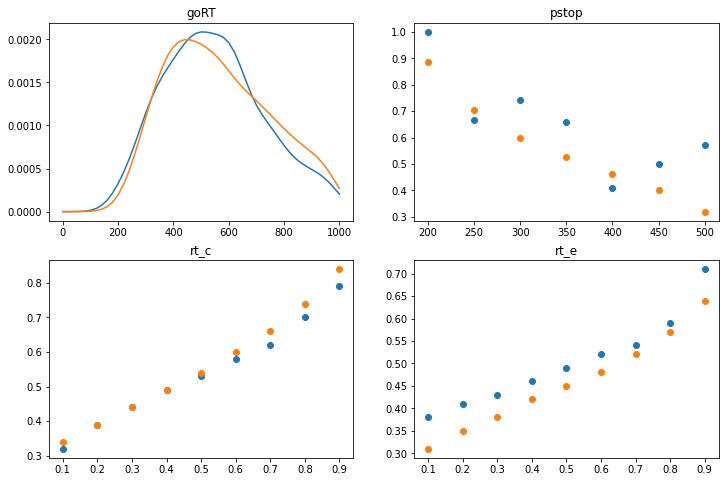

In [ ]:
i=0
sample = solver.result.mean(axis=0)
data = SimpleExperimentEnvironment(LinearSubject.new_subject(sample[0],0, sample[1],sample[2],sample[3],sample[4],sample[5])).auto_repeat(20)
data_df = data.to_pandas()
data_stats = aly.compute_stats(data, flatten=False)
go = data_df[data_df['trial_type']==1]
stop = data_df[data_df['trial_type']==0]
plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
plt.title("goRT")
x = np.linspace(0, 1000, 51).reshape(-1, 1)
kde2 = KernelDensity(kernel='gaussian', bandwidth=51).fit(aly.go_RT.to_numpy().reshape(-1, 1))
dens2 = np.exp(kde2.score_samples(x))
_ = plt.plot(x, dens2)
kde = KernelDensity(kernel='gaussian', bandwidth=51).fit(go['response'][go['response']>0].to_numpy().reshape(-1, 1))
dens = np.exp(kde.score_samples(x))
_ = plt.plot(x, dens)
plt.subplot(2,2,2)
plt.title("pstop")
x=aly.SSD_probe
p_target = aly.target_stats['p_stop']
p_now = data_stats['p_stop']
plt.scatter(aly.SSD_probe, p_target)
plt.scatter(aly.SSD_probe, p_now)
plt.subplot(2, 2, 3)
plt.title('rt_c')
plt.scatter(aly.RT_quantile, aly.target_stats['rt_c'])
plt.scatter(aly.RT_quantile, data_stats['rt_c'])
plt.subplot(2, 2, 4)
plt.title('rt_e')
plt.scatter(aly.RT_quantile, aly.target_stats['rt_e'])
plt.scatter(aly.RT_quantile, data_stats['rt_e'])

In [ ]:
sample

array([102.60978443,  -0.03670017,   0.0328165 ,   0.02793587,
         0.02188054,  12.69040529])

In [ ]:
SIM_params.iloc[26]

0    53.823671
1    -0.083967
2     0.059601
3     0.038200
4     0.033918
5    15.591817
Name: 47, dtype: float64

In [ ]:
model1 = LR()
model2 = LR()
def get_SSRT(i):
  aly = SIM_proc.get_analyzer(i, np.arange(0.1, 1, 0.1), False).analyze()
  return aly['medianssrt'], aly['nthssrt']

nthssrts = np.zeros(SIM_proc.num_subjects())
medianssrts = np.zeros(SIM_proc.num_subjects())

for i in range(SIM_proc.num_subjects()):
  ssrts = get_SSRT(i)
  medianssrts[i] = ssrts[0]
  nthssrts[i] = ssrts[1]

model1.fit(SIM_params, medianssrts)
model2.fit(SIM_params, nthssrts)

LinearRegression()

In [ ]:
model1.score(SIM_params, medianssrts)

0.8989644816500852

In [ ]:
model2.score(SIM_params, nthssrts)

0.7628380001210959